## Aprendizaje Automático II - Tarea 3 - Miguel Angel Ruiz Ortiz

Crear un modelo de codificador (encoder) de Transformer para dada una serie de $K$ entradas (horas) de valores de criptomonedas predecir los precios de las siguientes $k$ horas (ver  descripción en la tarea 2).

1. El transformer (encoder) debe constar de al menos 3 etapas. La salida debe ser directamente la predicción. 

2. Probar normalización: logarítmica y banqueo (restar min y dividir entre  (max-min) a cada cripto en la serie). 

3. Usar el prositional encoder propuesto en el Transformer original.

4. Comparar con el baseline de suponer que el precio de la criptomoneda no cambia durante el periodo de predicción, y con el Seq2Seq con atención de la tarea 2. 

## Librerías

In [1]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import math
from typing import Callable
from abc import ABC, abstractmethod
import seaborn as sns

In [2]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Funciones útiles

En esta sección definimos funciones útiles para el notebook para entrenar un modelo de la forma ``CustomModel`` (definido como clase abstracta) y plotear la función de costo y métrica durante su entrenamiento.

In [3]:
# Abstract class for typing util functions
class CustomModel(ABC):
    def __init__(self):
        self.model: keras.Model = None

    @abstractmethod
    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):
        pass

    @abstractmethod
    def predict(self, X_test: np.ndarray):
        pass

    @abstractmethod
    def compile(self, optimizer: keras.optimizers.Optimizer, loss: str, metrics: list[keras.metrics.Metric]):
        pass

In [4]:
def plot_training_metrics(
    model: CustomModel,
    metric: str,
    metric_name: str,
    loss_name: str,
    n_epochs: int,
    figsize: tuple[int, int] = (14, 5),
):
    # function to plot loss function and metric function when training the given CustomModel

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(
        range(1, n_epochs),
        model.model.history.history["loss"][1:],
        label="Entrenamiento",
    )
    plt.plot(
        range(1, n_epochs),
        model.model.history.history["val_loss"][1:],
        label="Validación",
    )
    plt.title("Función de pérdida")
    plt.xlabel("Época")
    plt.ylabel(loss_name)

    plt.subplot(1, 2, 2)
    plt.plot(model.model.history.history[metric], label="Entrenamiento")
    plt.plot(model.model.history.history[f"val_{metric}"], label="Validación")
    plt.title(metric_name)
    plt.xlabel("Época")
    plt.ylabel(metric)

    plt.legend()
    plt.show()

In [5]:
def train_model_and_plot(
    model: CustomModel,
    epochs: int, 
    adam_optimizer_params: dict,
    X: np.ndarray,
    decoder_input: np.ndarray,
    y: np.ndarray,
    X_val: np.ndarray,
    decoder_input_val: np.ndarray,
    y_val: np.ndarray
):
    # function to train given CustomModel and plot loss function and metric function
    
    model.compile(
        optimizer=keras.optimizers.Adam(**adam_optimizer_params),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError()],
    )

    model.fit(X, decoder_input, y, X_val, decoder_input_val, y_val, batch_size=64, epochs=epochs)

    plot_training_metrics(model=model, metric="mean_absolute_error", metric_name="Error absoluto medio", loss_name="Error cuadrático medio", n_epochs=epochs)

## Datos

### Datos (Yahoo Finance)

Pedimos con la librería ``yfinance`` para descargar el precio (con respecto al dólar) de una criptomoneda dada a través de la API de Yahoo Finance. Las criptomonedas que se consideraron son:
- Bitcoin (BTC), 
- Ethereum (ETH), 
- Binance Coin (BNB), 
- XRP (Ripple), 
- Cardano (ADA), 
- Solana (SOL), 
- Dogecoin (DOGE)

Los precios son cada hora, durante 1 año. Abarcan desde 2023-09-18 03:00:00+00:00 hasta 2024-09-18 02:00:00+00:00 (las mismas fechas que se usaron para los datos de la tarea 2). Además, se utilizó la estrategia de rellenar los valores faltantes hacia adelante ("forward fill"), i.e., con el dato disponible anterior.

Los datos se leen del archivo ``cryptocoins-timeseries.csv``, el cual se genera a través del script ``download_data.py``.

In [6]:
cryptos = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "SOL-USD", "DOGE-USD"]

dataset_df = pd.read_csv("cryptocoins-timeseries.csv", parse_dates=[0], index_col=0)

dataset_df.head()

BTC-USD      ETH-USD     BNB-USD   XRP-USD  \
2023-09-18 03:00:00+00:00  26659.097656  1629.741455  217.830093  0.497337   
2023-09-18 04:00:00+00:00  26624.929688  1630.428589  217.081177  0.497421   
2023-09-18 05:00:00+00:00  26668.037109  1631.512207  217.270325  0.495707   
2023-09-18 06:00:00+00:00  26672.318359  1630.511108  217.335846  0.493208   
2023-09-18 07:00:00+00:00  26712.169922  1634.266113  216.986725  0.491757   

                            ADA-USD    SOL-USD  DOGE-USD  
2023-09-18 03:00:00+00:00  0.249284  19.204222  0.061809  
2023-09-18 04:00:00+00:00  0.249350  19.059607  0.061723  
2023-09-18 05:00:00+00:00  0.249015  19.137966  0.061782  
2023-09-18 06:00:00+00:00  0.248663  19.120892  0.061766  
2023-09-18 07:00:00+00:00  0.248552  19.118294  0.061820

### Creación de datasets de entrenamiento, validación y prueba

Un elemento de nuestro dataset para el modelo es una secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ donde $x_j$ es un vector con los precios de las 7 criptomonedas al tiempo $j$. Dada dicha secuencia, el modelo va a predecir los siguientes $m$ datos, es decir, la secuencia $(x_{t+\tau}, ..., x_{t+\tau+m-1})$. Para poder aplicar el forzamiento del maestro ("teacher forcing"), el decoder necesita la secuencia que va a predecir pero trasladada un paso en el tiempo hacia atrás, i.e., $(x_{t+\tau-1}, ..., x_{t+\tau+m-2})$. 

Para que el modelo no tenga "información del futuro", se usarán los primeros ``n_train`` datos de cada serie para formar el conjunto de entrenamiento, los siguientes ``n_val`` para el conjunto de validación, y los últimos ``n_test`` para el conjunto de prueba. Es decir, los tiempo en el dataset de entrenamiento son antes que los tiempos en el dataset de validación, y a su vez estos tiempos son antes de los tiempos en el dataset de prueba.

In [7]:
data = dataset_df.to_numpy()

total_data = len(dataset_df)

n_train = int(total_data * 0.60)
n_val = int(total_data * 0.20)
n_test = total_data - n_train - n_val

print(f"Total de datos: {total_data}")
print(f"- Entrenamiento: {n_train} datos")
print(f"- Validación: {n_val} datos")
print(f"- Prueba: {n_test} datos")

train_data = data[:n_train]
val_data = data[n_train : n_train + n_val]
test_data = data[-n_test:]

Total de datos: 8784
- Entrenamiento: 5270 datos
- Validación: 1756 datos
- Prueba: 1758 datos


In [8]:
T = 100
m = 5
tau = T - m

Para evitar un sobreajuste, no le damos todas las posibles secuencias $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ del conjunto de entrenamiento, si no sólo un 85% de ellas de manera aleatoria.

In [9]:
np.random.seed(0)

train_indices = np.random.choice(
    n_train - T, int(0.85 * (n_train - T)), replace=False
)  # time for index i corresponds to time_index[i]

X_train_raw = np.array([train_data[i : i + T] for i in train_indices])
X_train_raw, y_train_raw, decoder_input_train_raw = (
    X_train_raw[:, : T - m, :].copy(),
    X_train_raw[:, -m:, :].copy(),
    X_train_raw[:, -m - 1 : -1, :].copy(),
)

X_val_raw = np.array([val_data[i : i + T] for i in range(n_val - T)])
X_val_raw, y_val_raw, decoder_input_val_raw = (
    X_val_raw[:, : T - m, :].copy(),
    X_val_raw[:, -m:, :].copy(),
    X_val_raw[:, -m - 1 : -1, :].copy(),
)

X_test_raw = np.array([test_data[i : i + T] for i in range(n_test - T)])
X_test_raw, y_test_raw, decoder_input_test_raw = (
    X_test_raw[:, : T - m, :].copy(),
    X_test_raw[:, -m:, :].copy(),
    X_test_raw[:, -m - 1 : -1, :].copy(),
)

In [10]:
time_index = dataset_df.index

def index2timestamp(i: int, dataset_type: str) -> pd.Timestamp:
    # auxiliar function to know the timestamp t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1}), given the index i in the corresponding dataset ("train", "val", "test")
    if dataset_type == "train":
        return time_index[i]
    if dataset_type == "val":
        return time_index[n_train + i]
    if dataset_type == "test":
        return time_index[-n_test + i]

### Preprocesamiento

Vamos a utilizar las siguientes estrategias de preprocesamiento de los datos:
1. Normalización local: a cada secuencia se le calcula su propia media y desviación estándar para normalizar sólo esa secuencia por cada criptomoneda.
2. Banqueo (Min-Max scaling) local: cada secuencia se transforma al intervalo [0, 1] de manera lineal, utilizando el máximo y el mínimo de esa secuencia.
3. Escala logarítmica: se aplica logaritmo a las series de tiempo.

Recordemos que las series de tiempo financieras tienen un comportamiento cambiante a lo largo del tiempo, por ejemplo una volatilidad (varianza) que depende del tiempo tiempo. Por esto conviene utilizar un preprocesamiento *local* de los datos, en la que se aplica el preprocesamiento a cada secuencia de input. En el caso de la normalización local, a cada secuencia se le calcula su propia media y desviación estándar para normalizar sólo esa secuencia por cada criptomoneda.

#### Normalización local

In [11]:
class LocalNormalization:
    def __init__(self, sequences: np.ndarray):
        # compute vector of means and standard deviations, for each sequence
        
        self.means = sequences.mean(axis=1)  # vector mu of means for each sequence, i.e., mu[i] is the vector of means for each feature of sequence i
        self.stds = sequences.std(axis=1)  # vector of standard deviations for each sequence
    
    def transform(self, sequences: np.ndarray) -> np.ndarray:
        sequences_norm = np.zeros(sequences.shape)
        
        for i in range(sequences.shape[0]):
            sequences_norm[i] = (sequences[i] - self.means[i]) / self.stds[i]
            
        return sequences_norm
    
    def inverse_transform(self, sequences_norm: np.ndarray) -> np.ndarray:
        sequences_raw = np.zeros(sequences_norm.shape)

        for i in range(sequences_norm.shape[0]):
            sequences_raw[i] = self.stds[i] * sequences_norm[i] + self.means[i]

        return sequences_raw

In [12]:
norm_train = LocalNormalization(X_train_raw)
X_train_norm = norm_train.transform(X_train_raw)
y_train_norm = norm_train.transform(y_train_raw)
decoder_input_train_norm = norm_train.transform(decoder_input_train_raw)

norm_val = LocalNormalization(X_val_raw)
X_val_norm = norm_val.transform(X_val_raw)
y_val_norm = norm_val.transform(y_val_raw)
decoder_input_val_norm = norm_val.transform(decoder_input_val_raw)

norm_test = LocalNormalization(X_test_raw)
X_test_norm = norm_test.transform(X_test_raw)
y_test_norm = norm_test.transform(y_test_raw)
decoder_input_test_norm = norm_test.transform(decoder_input_test_raw)

#### Banqueo (Min-Max scaling) local

In [13]:
class LocalMinMaxScaling:
    def __init__(self, sequences: np.ndarray):
        # compute vector of minimums and maximums, for each sequence
        
        self.min = sequences.min(axis=1)  # vector of minimums for each sequence, i.e.,  min[i] is the vector of minimums of each feature in sequence i
        self.max = sequences.max(axis=1)  # vector of maximums for each sequence
    
    def transform(self, sequences: np.ndarray) -> np.ndarray:
        sequences_scaled = np.zeros(sequences.shape)
        
        for i in range(sequences.shape[0]):
            sequences_scaled[i] = (sequences[i] - self.min[i]) / (self.max[i] - self.min[i])
            
        return sequences_scaled
    
    def inverse_transform(self, sequences_scaled: np.ndarray) -> np.ndarray:
        sequences_raw = np.zeros(sequences_scaled.shape)

        for i in range(sequences_scaled.shape[0]):
            sequences_raw[i] = (self.max[i] - self.min[i]) * sequences_scaled[i] + self.min[i]

        return sequences_raw

In [14]:
minmax_scaler_train = LocalMinMaxScaling(X_train_raw)
X_train_minmax = minmax_scaler_train.transform(X_train_raw)
y_train_minmax = minmax_scaler_train.transform(y_train_raw)
decoder_input_train_minmax = minmax_scaler_train.transform(decoder_input_train_raw)

minmax_scaler_val = LocalMinMaxScaling(X_val_raw)
X_val_minmax = minmax_scaler_val.transform(X_val_raw)
y_val_minmax = minmax_scaler_val.transform(y_val_raw)
decoder_input_val_minmax = minmax_scaler_val.transform(decoder_input_val_raw)

minmax_scaler_test = LocalMinMaxScaling(X_test_raw)
X_test_minmax = minmax_scaler_test.transform(X_test_raw)
y_test_minmax = minmax_scaler_test.transform(y_test_raw)
decoder_input_test_minmax = minmax_scaler_test.transform(decoder_input_test_raw)

#### Escala logarítmica

In [15]:
X_train_log = np.log(X_train_raw)
y_train_log = np.log(y_train_raw)
decoder_input_train_log = np.log(decoder_input_train_raw)

X_val_log = np.log(X_val_raw)
y_val_log = np.log(y_val_raw)
decoder_input_val_log = np.log(decoder_input_val_raw)

X_test_log = np.log(X_test_raw)
y_test_log = np.log(y_test_raw)
decoder_input_test_log = np.log(decoder_input_test_raw)

## Seq2Seq + Atención

En esta sección sólo volvemos a utilizar el código de la tarea 2 para obtener las predicciones hechas del modelo Seq2Seq con atención. Recordemos que en dicha tarea sólo aplicamos el Seq2Seq con atención a los datos con normalización local.

In [16]:
class MultiplicativeAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        # dense layer to compute multiplicative style scores
        self.score_dense = keras.layers.Dense(units, use_bias=False)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
        query, key = (
            inputs  # query are the hidden states of decoder, and key are the hidden states of encoder
        )

        # Compute attention scores QxWxK^T
        scores = tf.matmul(query, self.score_dense(key), transpose_b=True)

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Compute context vector as weighted average of encoder's hidden states
        context = tf.matmul(attention_weights, key)

        return context, attention_weights


class Seq2SeqAttention:
    def __init__(self, latent_dim: int, dim_vectors: int, n_steps: int):
        self.dim_vectors = dim_vectors
        self.n_steps = n_steps

        # encoder
        encoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        encoder_o, encoder_h, encoder_c = keras.layers.LSTM(
            units=latent_dim, return_sequences=True, return_state=True
        )(encoder_inputs)
        encoder_states = [encoder_h, encoder_c]

        # decoder
        decoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        decoder_lstm = keras.layers.LSTM(
            units=latent_dim, return_sequences=True, return_state=True
        )
        decoder_o, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

        attention_layer = MultiplicativeAttention(latent_dim)
        context, attention_weights = attention_layer([decoder_o, encoder_o])

        # Concatenate attention output and decoder LSTM output
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([decoder_o, context])

        # last dense layer
        decoder_dense = keras.layers.Dense(dim_vectors)
        decoder_outputs = decoder_dense(decoder_concat_input)

        # Define the full model that will be trained with teacher forcing
        self.model = keras.models.Model(
            [encoder_inputs, decoder_inputs], decoder_outputs
        )

        # encoder for inference
        self.encoder_model = keras.models.Model(
            encoder_inputs, [encoder_o] + encoder_states
        )

        # adapted decoder for inference, using one output decoder as the next input of it
        decoder_state_input_h = keras.layers.Input(shape=(latent_dim,))
        decoder_state_input_c = keras.layers.Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        encoder_o_inf = keras.layers.Input(shape=(None, latent_dim))

        decoder_inf_o, state_h, state_c = decoder_lstm(
            decoder_inputs, initial_state=decoder_states_inputs
        )
        context_inf, attention_weights_inf = attention_layer(
            [decoder_inf_o, encoder_o_inf]
        )
        decoder_inf_concat = keras.layers.Concatenate(axis=-1)(
            [decoder_inf_o, context_inf]
        )
        decoder_inf_outputs = decoder_dense(decoder_inf_concat)

        self.decoder_model = keras.models.Model(
            [decoder_inputs, encoder_o_inf] + decoder_states_inputs,
            [decoder_inf_outputs, state_h, state_c],
        )

    def compile(
        self,
        optimizer: keras.optimizers.Optimizer,
        loss: str,
        metrics: list[keras.metrics.Metric],
    ):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):

        self.model.fit(
            [X_train, decoder_input_train],
            y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kwargs
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        encoder_o, state_h, state_c = self.encoder_model.predict(X_test)
        last_values = X_test[:, -1:, :]
        pred_test = np.zeros(shape=(X_test.shape[0], self.n_steps, self.dim_vectors))

        for i in range(self.n_steps):
            last_values, state_h, state_c = self.decoder_model.predict(
                [last_values, encoder_o, state_h, state_c]
            )
            pred_test[:, i, :] = last_values[:, 0, :]

        return pred_test

Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_76']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1.7202 - mean_absolute_error: 0.9738 - val_loss: 0.5234 - val_mean_absolute_error: 0.5268
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.3933 - mean_absolute_error: 0.4339 - val_loss: 0.2356 - val_mean_absolute_error: 0.3167
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.2473 - mean_absolute_error: 0.3139 - val_loss: 0.1991 - val_mean_absolute_error: 0.2880
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.2051 - mean_absolute_error: 0.2882 - val_loss: 0.2035 - val_mean_absolute_error: 0.2919
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.1922 - mean_absolute_error: 0.2805 - val_loss: 0.2098 - val_mean_absolute_error: 0.2943
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1928 - mean_absolute_error: 0.2776 - val_loss: 0.1839 - val_mean_absolute_error: 0.2729
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1894 - mean_absolute_error: 0.2682 - val_loss: 0.1764 - 

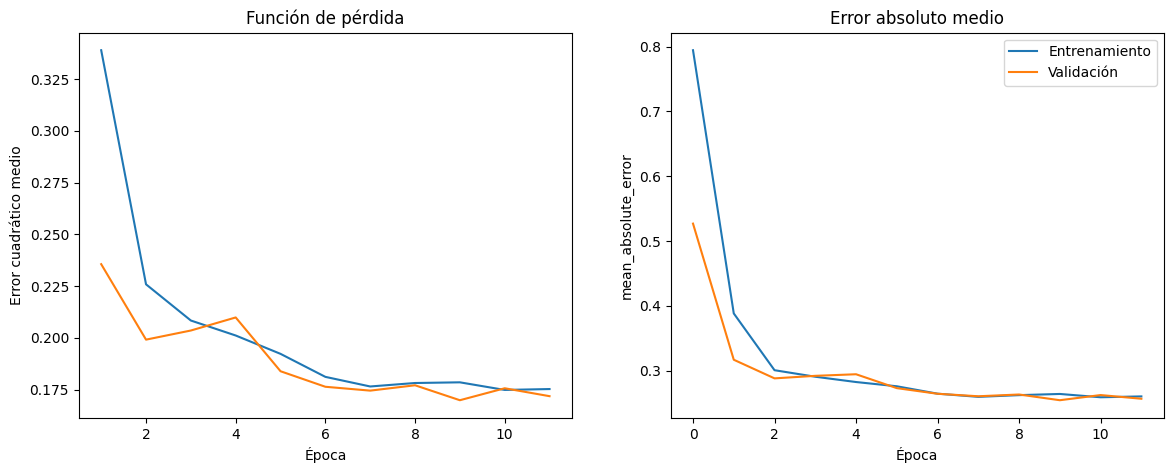

In [21]:
latent_dim = 512
dim_vectors = 7

seq2seq_attention_model = Seq2SeqAttention(latent_dim, dim_vectors, n_steps=m)

epochs = 12

train_model_and_plot(
    model=seq2seq_attention_model,
    epochs=epochs,
    adam_optimizer_params={}, # default Adam optimizer as in last homework
    X=X_train_norm,
    decoder_input=decoder_input_train_norm,
    y=y_train_norm,
    X_val=X_val_norm,
    decoder_input_val=decoder_input_val_norm,
    y_val=y_val_norm,
)

In [22]:
n_features = 7

pred_seq2seq = seq2seq_attention_model.predict(X_test_norm)  # predictions
pred_seq2seq_flat = pred_seq2seq.reshape(-1, n_features)
y_test_norm_flat = y_test_norm.reshape(-1, n_features)  # ground truth

mae_seq2seq = mean_absolute_error(y_test_norm_flat, pred_seq2seq_flat, multioutput="raw_values")

print("\nErrores absolutos medios en la escala normalizada:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seq[i])

pred_seq2seq_raw = norm_test.inverse_transform(pred_seq2seq)  # predicted prices
pred_raw_flat = pred_seq2seq_raw.reshape(-1, n_features)
y_test_raw_flat = y_test_raw.reshape(-1, n_features)

mae_seq2seq_raw = mean_absolute_error(
    y_test_raw_flat, pred_raw_flat, multioutput="raw_values"
)

print("\nErrores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seq_raw[i])

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_76', 'keras_tensor_88', 'keras_tensor_86', 'keras_tensor_87']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.38773011106582334
ETH-USD : 0.45936120676747033
BNB-USD : 0.43439284866835565
XRP-USD : 0.49897944444015446
ADA-USD : 0.46989400735506126
SOL-USD : 0.4278570031490405
DOGE-USD : 0.45896979790526665

Errores absolutos medios en la escala de los precios:
BTC-USD : 430.5086385805269
ETH-USD : 25.64868064159424
BNB-USD : 4.396489042838748
XRP-USD : 0.006539001220649601
ADA-USD : 0.004233254726588214
SOL-USD : 1.7351336497883203
DOGE-USD : 0.0013357667588418934


## Transformer Encoder

La arquitectura del encoder del Transformer se muestra en el siguiente diagrama:

<div style="text-align: center">
<img src="transformer-encoder.png" height="500px" />
</div>

### Positional embedding

Implementamos la capa de *positional embedding* en la que se suma a los embeddings de input un vector que contiene la información de la posicición de un vector en la secuencia. El vector $PE_{pos}$ que se le suma al vector en la posición *pos* de una secuencia está dado por
$$
PE_{pos}[2i] = \sin(pos/10000^{2i/d}), \quad \quad PE_{pos}[2i+1] = \cos(pos/10000^{2i/d})
$$
donde $d$ es la dimensión de los embeddings de input, y $2i, 2i+1$ representan una dimensión del *positional encoding* $PE_{pos}$.

In [23]:
def positional_embedding(pos: int, k: int, d_model: int) -> float:
    i = k // 2  # k = 2*i + (k%2)

    if k % 2 == 0:
        return math.sin(pos / (10000 ** (2 * i / d_model)))
    else:
        return math.cos(pos / (10000 ** (2 * i / d_model)))


class ClassicPositionalEmbedding(keras.Layer):
    def __init__(self, max_length: int, d_model: int):
        super().__init__()
        
        self.max_length = max_length

        # creating positional encodings
        self.pos_encoding = tf.constant(
            [
                [positional_embedding(pos, k, d_model) for k in range(d_model)]
                for pos in range(max_length)
            ]
        )

    def call(self, inputs):
        # add positional encoding to input
        # we assume inputs have shape (batch_size, N, d_model), where N <= max_length
        # if inputs_length is None, then we assume inputs_length equals max_length
        N = inputs.shape[1]
            
        return inputs + self.pos_encoding[:N, :]

### Subcapa Feed-forward and capa del encoder

En el diagrama se observa que después del *positional embedding* se itera $N$ veces (en esta tarea $N=3$) una capa implementada en la clase ``EncoderLayer``.  Esta capa se compone de un mecanismo de atención multi-cabeza y una red *feed-forward* con dos capas densas. También consta de conexiones residuales alrededor de ambos procesos seguido de una normalización de capa (``LayerNormalization``). Se implementó en la clase ``FeedForward`` la subcapa compuesta de la red *feed-forward* con la conexión residual y la normalización de capa.

In [24]:
class FeedForward(tf.keras.Layer):
    def __init__(self, d_model: int, dff: int):
        super().__init__()

        # two linear transformations with a ReLU activation function between
        self.feedforward_net = keras.models.Sequential(
            [
                keras.layers.Dense(dff, activation="relu"),
                keras.layers.Dense(d_model),
            ]
        )

        # Residual connection
        self.add = tf.keras.layers.Add()

        # Layer Normalization
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        x = self.feedforward_net(inputs)
        x = self.add([inputs, x])
        x = self.layer_norm(x)
        return x


class EncoderLayer(keras.Layer):
    def __init__(self, num_heads: int, dim_qkv: int, d_model: int, dff: int):
        super().__init__()

        # Multi-Head attention layer
        self.multi_head_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim_qkv, use_bias=False
        )

        # Residual connection
        self.add_layer = keras.layers.Add()

        # Layer Normalization
        self.layer_norm = keras.layers.LayerNormalization()

        # Feed-Forward Network
        self.ff_sublayer = FeedForward(d_model=d_model, dff=dff)

    def call(self, inputs):
        x = self.multi_head_attention(query=inputs, value=inputs)
        x = self.add_layer([inputs, x])
        x = self.layer_norm(x)
        x = self.ff_sublayer(x)

        return x

### Encoder del Transformer

Finalmente pegamos todas las piezas del encoder del Transformer, tomando en cuenta que ``EncoderLayer`` se debe iterar un número ``n_layers`` dado de veces. El modelo recibe el número ``num_head`` de cabezas a usar en el mecanismo de atención, la dimensión del input embedding ``d_model``, la dimensión ``dim_qkv`` de las proyecciones que entran a las cabezas de atención, la longitud ``sequence_length`` de las secuencias de input, y el número de neuronas ``dff`` que se usan en distintas capas densas a lo largo del pipeline.

In [25]:
class TransformerEncoder(keras.Model):
    def __init__(
        self,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
    ):
        super().__init__()
        
        self.num_head = num_heads
        self.n_layers = n_layers
        self.d_model = d_model
        self.dim_qkv = dim_qkv

        self.positional_encoding = ClassicPositionalEmbedding(
            max_length=sequence_length, d_model=d_model
        )
        self.encoder_layers = [
            EncoderLayer(num_heads=num_heads, dim_qkv=dim_qkv, d_model=d_model, dff=dff) for _ in range(n_layers)
        ]

    def call(self, inputs):
        x = self.positional_encoding(inputs)

        for i in range(self.n_layers):
            x = self.encoder_layers[i](x)
            
        return x
        

### Decoder customizado

El output del encoder es una secuencia de longitud ``sequence_length`` de vectores de dimensión ``d_model``. Por lo que nos falta un decoder que transforme esa secuencia en la secuencia de predicción de longitud ``pred_steps``. El decoder que aquí usamos trata de imitar al decoder del Transformer pero quitando el mecanismo de atención enmascarada (*Masked Multi-Head Attention*). Recordemos que el decoder tiene como input la secuencia que va a predecir pero trasladada un tiempo hacia atrás. El flujo del decoder es el siguiente: 
1. A la secuencia input del decoder se le suma el *Positional Encoding*.
2. Se realiza un mecanismo de atención multi-cabeza en la que la *query* es el estado del decoder, mientras que la *key* y el *value* es el output del encoder.
3. Conexión residual entre el input y el output del mecanismo de atención, seguido de una normalización de capa (``LayerNormalization``).
4. Se aplica una red *feed-forward* con dos capas densas. 

Los pasos 2, 3 y 4 se iteran un número dado de veces como en el encoder.

In [26]:
class CustomDecoderLayer(keras.Layer):
    def __init__(self, num_heads: int, dim_qkv: int, d_model: int, dff: int):
        super().__init__()

        # Multi-Head attention layer
        self.multi_head_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim_qkv, use_bias=False
        )

        # Residual connection
        self.add_layer = keras.layers.Add()

        # Layer Normalization
        self.layer_norm = keras.layers.LayerNormalization()

        # Feed-Forward
        self.ff_sublayer = FeedForward(d_model=d_model, dff=dff)

    def call(self, query, value):
        # query is the decoder layer input, while value is the output of the encoder

        x = self.multi_head_attention(query=query, value=value)
        x = self.add_layer([query, x])
        x = self.layer_norm(x)
        x = self.ff_sublayer(x)

        return x


class CustomDecoder(keras.Model):
    def __init__(
        self,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
    ):
        super().__init__()

        self.num_head = num_heads
        self.n_layers = n_layers
        self.d_model = d_model
        self.dim_qkv = dim_qkv

        self.positional_encoding = ClassicPositionalEmbedding(
            max_length=sequence_length, d_model=d_model
        )
        self.decoder_layers = [
            CustomDecoderLayer(
                num_heads=num_heads, dim_qkv=dim_qkv, d_model=d_model, dff=dff
            )
            for _ in range(n_layers)
        ]

    def call(self, query, value):
        # query is the decoder input, while value is the output of the encoder
        x = self.positional_encoding(query)

        for i in range(self.n_layers):
            x = self.decoder_layers[i](x, value)

        return x

### Predicción de series de tiempo usando el encoder del Transformer + decoder customizado

Finalmente definimos el modelo completo utilizando el encoder del Transformer y nuestro decoder. Para esto se aplica un embedding a los datos de entrada (se multiplica por una matriz de tamaño ``data_dim x d_model``, donde ``data_dim`` es la dimensión de los vectores en las secuencias y ``d_model`` es la dimensión del espacio latente del modelo). Recordemos que aquí ``data_dim = 7`` es el número de criptomonedas, y utilizamos ``d_model = 256`` como dimensión del espacio latente.

In [27]:
class TimeSeriesModel:
    def __init__(
        self,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        data_dim: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
        pred_steps: int,
    ):
        self.pred_steps = pred_steps
        self.data_dim = data_dim
        
        # dense layer for data embedding
        self.input_embedding = keras.layers.Dense(d_model, use_bias=False)
        
        # dense layer to project model output in dimension data
        self.output_projection = keras.layers.Dense(data_dim, use_bias=False)

        # transformer encoder
        self.transformer_encoder = TransformerEncoder(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff,
        )

        # custom decoder
        self.custom_decoder = CustomDecoder(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff
        )

        # pipeline definition
        encoder_inputs = keras.layers.Input(shape=(None, data_dim))
        decoder_inputs = keras.layers.Input(shape=(None, data_dim))
        
        encoder_inputs_embedded = self.input_embedding(encoder_inputs)
        encoder_output = self.transformer_encoder(encoder_inputs_embedded)
        
        decoder_inputs_embedded = self.input_embedding(decoder_inputs)
        output_decoder = self.custom_decoder(decoder_inputs_embedded, encoder_output)
        output_seq = self.output_projection(output_decoder)

        self.model = keras.Model([encoder_inputs, decoder_inputs], output_seq)

    def compile(
        self,
        optimizer: keras.optimizers.Optimizer,
        loss: str,
        metrics: list[keras.metrics.Metric],
    ):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):
        self.model.fit(
            [X_train, decoder_input_train],
            y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kwargs
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        encoder_input = self.input_embedding(X_test)
        encoder_output = self.transformer_encoder.predict(encoder_input)
        
        decoder_input = X_test[:, -1:, :]  # decoder input first is the last step of the input

        pred_test = np.zeros(shape=(X_test.shape[0], self.pred_steps, self.data_dim))

        for i in range(self.pred_steps):
            decoder_input_embedded = self.input_embedding(decoder_input) # data embedding
            output_decoder = self.custom_decoder(decoder_input_embedded, encoder_output)  # shape = (batch_size, decoder_input_length, d_model)
            output_seq = self.output_projection(output_decoder) # shape = (batch_size, decoder_input_length, data_dim)
            pred_test[:, i, :] = output_seq[:, -1, :]  # select only the predicted new step
            decoder_input = tf.concat([decoder_input, output_seq[:, -1:, :]], axis=1)

        return pred_test

## Entrenamiento

Parámetros del modelo

In [28]:
num_heads = 3
data_dim = 7 # number of cryptos
d_model = 256 # latent space dimension 
dim_qkv = 64 # dimension of query, key and values for MultiHeadAttention layer
dff = 512 # number of neurons of first layer in feed-forward networks
n_layers = 3

#### Modelo para datos con normalización local

Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_96', 'keras_tensor_97']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - loss: 2.3270 - mean_absolute_error: 0.9213 - val_loss: 0.1839 - val_mean_absolute_error: 0.2644
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.1877 - mean_absolute_error: 0.2717 - val_loss: 0.1867 - val_mean_absolute_error: 0.2694
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.1766 - mean_absolute_error: 0.2719 - val_loss: 0.2042 - val_mean_absolute_error: 0.2921
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 0.1797 - mean_absolute_error: 0.2691 - val_loss: 0.1932 - val_mean_absolute_error: 0.2783
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.1801 - mean_absolute_error: 0.2737 - val_loss: 0.1831 - val_mean_absolute_error: 0.2700
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.1760 - mean_absolute_error: 0.2643 - val_loss: 0.1922 - val_mean_absolute_error: 0.2832
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 0.1770 - mean_absolute_error: 0.2653 - val_l

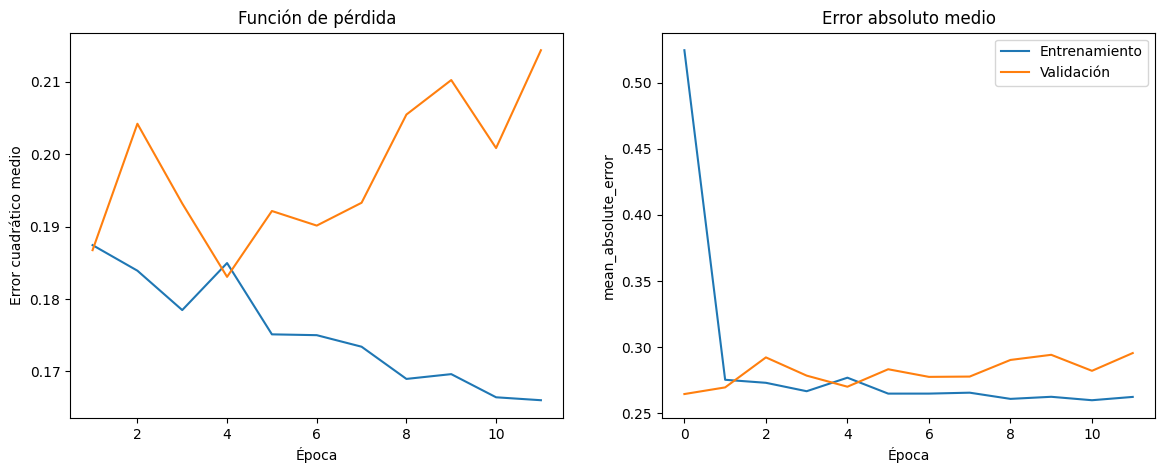

In [29]:
model_norm = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 12

train_model_and_plot(
    model=model_norm,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X_train_norm,
    decoder_input=decoder_input_train_norm,
    y=y_train_norm,
    X_val=X_val_norm,
    decoder_input_val=decoder_input_val_norm,
    y_val=y_val_norm,
)

#### Modelo para datos con banqueo local

Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_135', 'keras_tensor_136']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 279ms/step - loss: 1.5937 - mean_absolute_error: 0.6841 - val_loss: 0.0524 - val_mean_absolute_error: 0.1756
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - loss: 0.0432 - mean_absolute_error: 0.1546 - val_loss: 0.0294 - val_mean_absolute_error: 0.1274
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0237 - mean_absolute_error: 0.1118 - val_loss: 0.0186 - val_mean_absolute_error: 0.0988
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0136 - mean_absolute_error: 0.0827 - val_loss: 0.0123 - val_mean_absolute_error: 0.0770
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0124 - mean_absolute_error: 0.0775 - val_loss: 0.0109 - val_mean_absolute_error: 0.0702
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0103 - mean_absolute_error: 0.0684 - val_loss: 0.0109 - val_mean_absolute_error: 0.0697
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.0109 - mean_absolute_error: 0.0718 - val_l

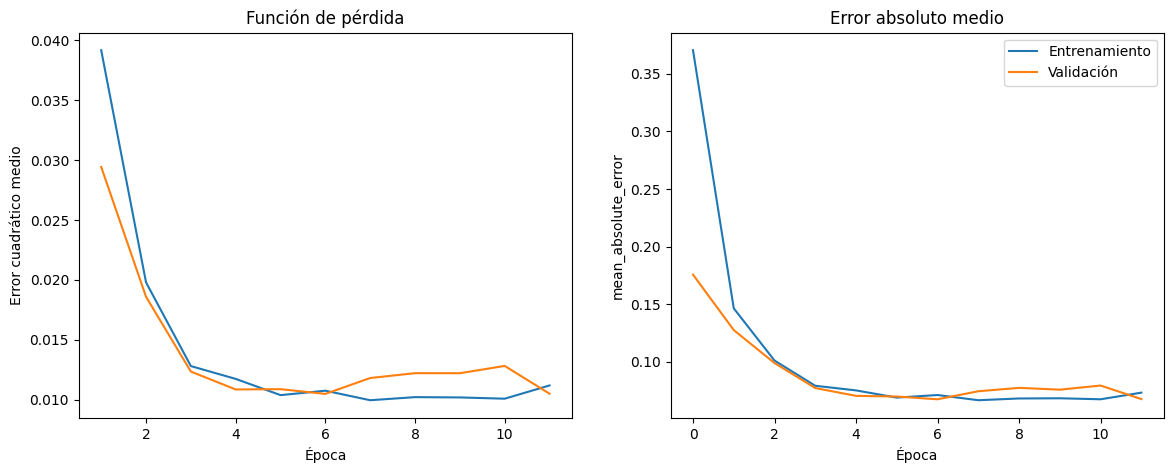

In [30]:
model_minmax = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 12

train_model_and_plot(
    model=model_minmax,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X_train_minmax,
    decoder_input=decoder_input_train_minmax,
    y=y_train_minmax,
    X_val=X_val_minmax,
    decoder_input_val=decoder_input_val_minmax,
    y_val=y_val_minmax,
)

#### Modelo para datos en escala logarítmica

Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_213', 'keras_tensor_214']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 357ms/step - loss: 3.6898 - mean_absolute_error: 0.7475 - val_loss: 0.1649 - val_mean_absolute_error: 0.3376
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.1672 - mean_absolute_error: 0.3083 - val_loss: 0.1363 - val_mean_absolute_error: 0.3291
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0296 - mean_absolute_error: 0.1320 - val_loss: 0.0411 - val_mean_absolute_error: 0.1603
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 0.0071 - mean_absolute_error: 0.0650 - val_loss: 0.0411 - val_mean_absolute_error: 0.1781
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0067 - mean_absolute_error: 0.0630 - val_loss: 0.0287 - val_mean_absolute_error: 0.1351
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0060 - mean_absolute_error: 0.0593 - val_loss: 0.0319 - val_mean_absolute_error: 0.1434
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0064 - mean_absolute_error: 0.0612 - val_l

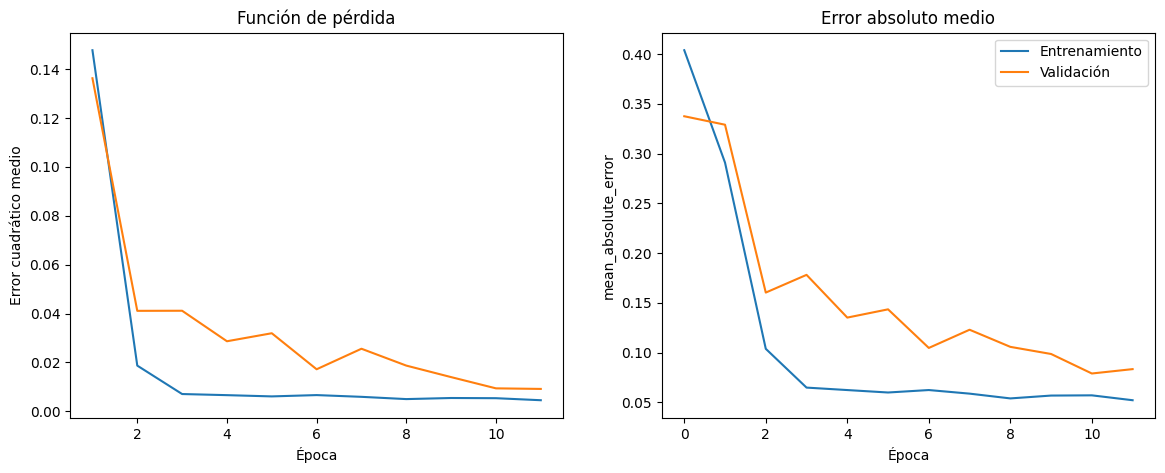

In [32]:
model_log = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 12

train_model_and_plot(
    model=model_log,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X_train_log,
    decoder_input=decoder_input_train_log,
    y=y_train_log,
    X_val=X_val_log,
    decoder_input_val=decoder_input_val_log,
    y_val=y_val_log,
)

## Inferencia

Por cada tipo de preprocesamiento, vamos a predecir con el conjunto de prueba y obtener el error absoluto medio obtenido en cada serie de tiempo en la escala de los datos preprocesados y en la escala de los precios. La predicciones se verán gráficamente escogiendo aleatoriamente 4 tiempos $t$ para visualizar la secuencia real y la secuencia predicha por cada criptomoneda, en una vecindad de dichos tiempos. 

Para tener una referencia, *baseline*, vamos a comparar los modelos con la predicción que consiste en mantener el último valor de la secuencia input constante en la secuencia de predicción, es decir, dada la secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ como input predecir la secuencia $(x_{t+\tau-1}, ..., x_{t+\tau-1})$ de tamaño $m$.

Las siguientes son funciones auxiliares para reproducir las gráficas mencionadas y para calcular el error absoluto medio (en la escala de los datos preprocesados y en la escala de los precios) de un modelo dado.

In [33]:
def plot_predictions(predictions: np.ndarray, random_seed: int = 0, window_size: int = 40):
    # function to plot predictions in four random times and for each crypto. 
    # columns in plot correspond to the selected times, and rows correspond to cryptos.
    
    np.random.seed(random_seed)
    rand_ind = np.random.choice(n_test-T, size=4, replace=False)
    
    n_rows, n_cols = 7, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

    fig.suptitle("Predicciones de precios", fontsize=22)

    # Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
    for j in range(n_cols):
        jth_time = index2timestamp(rand_ind[j], "test") # time t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1})
        jth_data = dataset_df.loc[
            jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
        ] # from the window of size T starting at t, just consider the last window_size points
        
        pred_times = jth_data.index[-m:] # predicted times
        last_time = jth_data.index[-m-1] # last time t+\tau -1
        
        for i in range(n_rows):
            ith_crypto = cryptos[i]
            last_price = dataset_df.loc[last_time][ith_crypto]
            
            axes[i, j].plot(jth_data[ith_crypto], label="Precios")
            axes[i, j].plot([last_time]+[t for t in pred_times], [last_price]+[pt for pt in predictions[rand_ind[j], :, i]], color="r", alpha=0.3)
            axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
            axes[i, j].scatter([last_time] + [t for t in pred_times], [last_price]*(m+1), color="b", label="Baseline")
            axes[i, j].scatter(pred_times, predictions[rand_ind[j], :, i], color="r", label="Predicciones")
            axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
            axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
            axes[i, j].tick_params(axis="x", labelrotation=45)
            axes[i,j ].legend(fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [36]:
def predictions_analysis(
    model: TimeSeriesModel,
    X_test: np.ndarray,
    y_test: np.ndarray,
    y_test_raw: np.ndarray,
    back2rawdata: Callable[[np.ndarray], np.ndarray],
    random_seed: int = 0,
    window_size: int = 40
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Function to predict from given data and given TimeSeriesModel, and compute mean absolute error from in preprocessed data scale and real scale
    
    pred = model.predict(X_test)  # predictions
    pred_flat = pred.reshape(-1, data_dim)
    y_test_flat = y_test.reshape(-1, data_dim)  # ground truth

    mae = mean_absolute_error(y_test_flat, pred_flat, multioutput="raw_values")

    print("\nErrores absolutos medios en la escala normalizada:")
    for i, crypto in enumerate(cryptos):
        print(crypto, ":", mae[i])

    pred_raw = back2rawdata(pred)  # predicted prices
    pred_raw_flat = pred_raw.reshape(-1, data_dim)
    y_test_raw_flat = y_test_raw.reshape(-1, data_dim)

    mae_raw = mean_absolute_error(
        y_test_raw_flat, pred_raw_flat, multioutput="raw_values"
    )

    print("\nErrores absolutos medios en la escala de los precios:")
    for i, crypto in enumerate(cryptos):
        print(crypto, ":", mae_raw[i])
    
    plot_predictions(predictions=pred_raw, random_seed=random_seed, window_size=window_size)

    return pred, pred_raw, mae, mae_raw

#### Predicción con normalización local

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.49378963273901827
ETH-USD : 0.7321397815820511
BNB-USD : 0.5439775409175253
XRP-USD : 0.600571175808593
ADA-USD : 0.44868258662161226
SOL-USD : 0.4657798302437817
DOGE-USD : 0.4086000450536218

Errores absolutos medios en la escala de los precios:
BTC-USD : 586.54737216536
ETH-USD : 49.762701011383214
BNB-USD : 5.808600795934513
XRP-USD : 0.007836548989971414
ADA-USD : 0.003931281943819157
SOL-USD : 2.002958218738845
DOGE-USD : 0.0011940909301235815


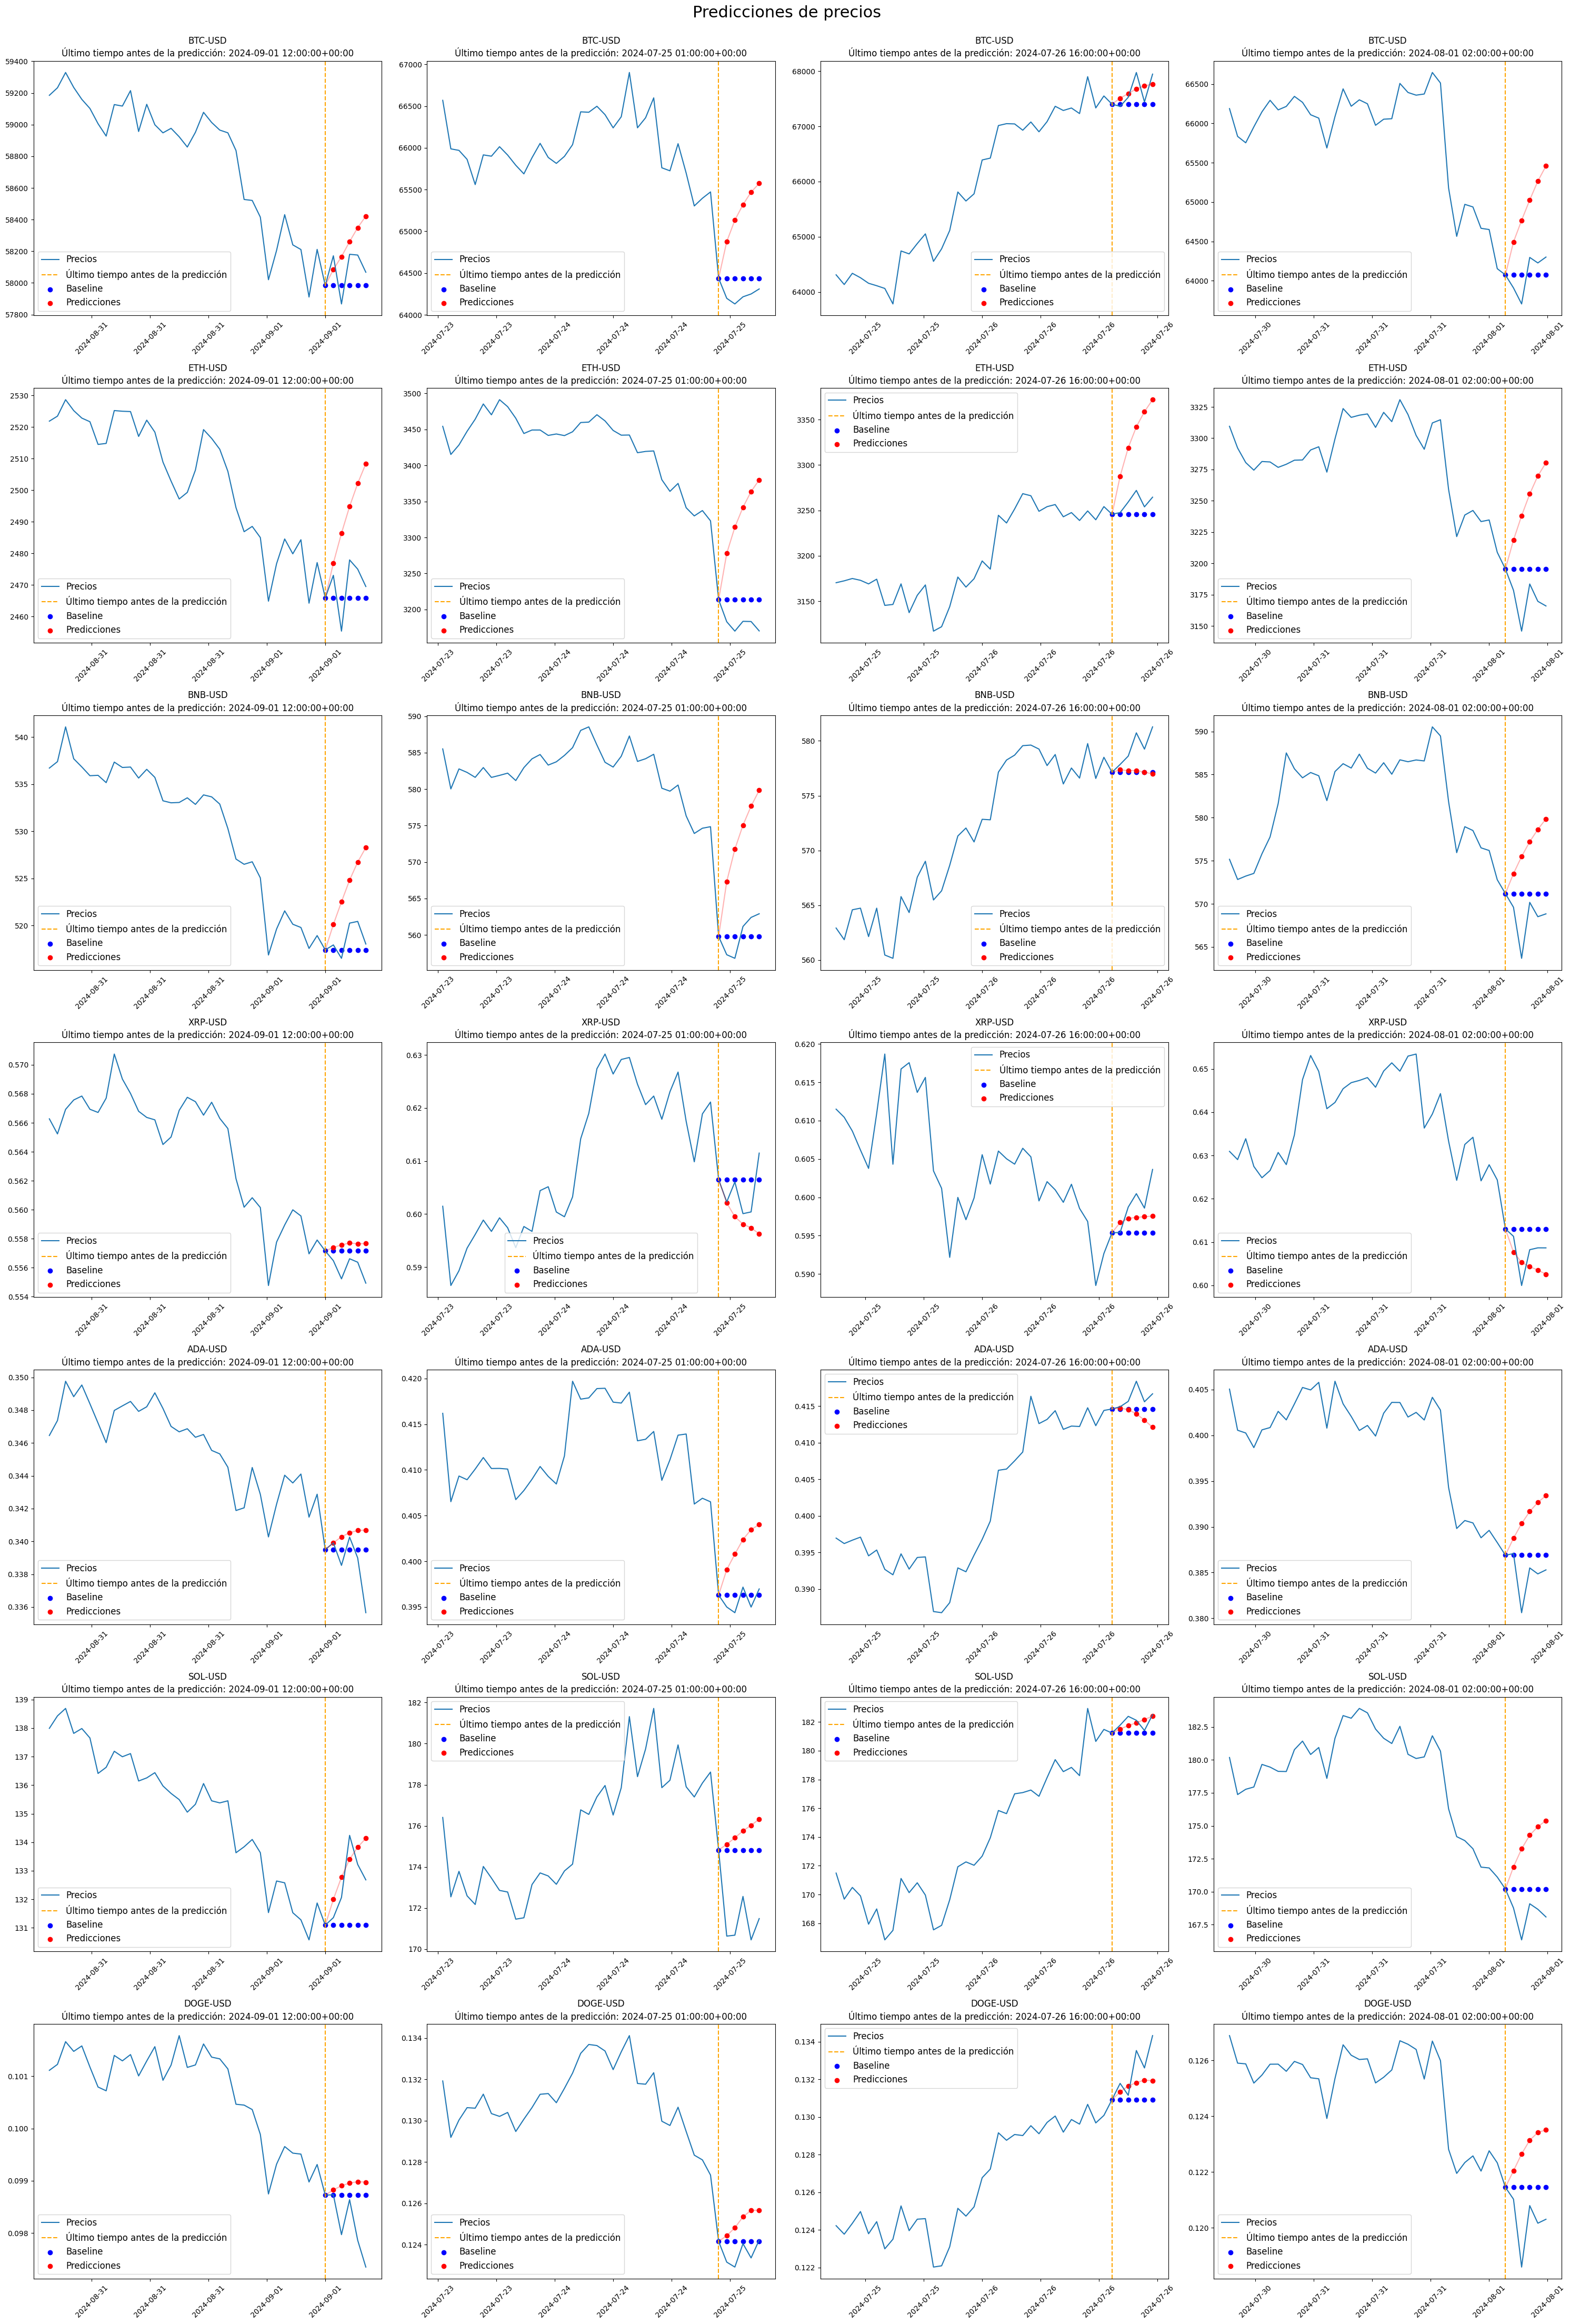

In [37]:
pred_norm, pred_norm_raw, mae_norm, mae_norm_raw = predictions_analysis(
    model=model_norm,
    X_test=X_test_norm,
    y_test=y_test_norm,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: norm_test.inverse_transform(data),
)

#### Predicción con banqueo (Min-Max scaling) local

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.12263443032528062
ETH-USD : 0.1482717854508143
BNB-USD : 0.14029016283207027
XRP-USD : 0.19555175387797033
ADA-USD : 0.1102550109961646
SOL-USD : 0.10323574868679421
DOGE-USD : 0.10732482981835512

Errores absolutos medios en la escala de los precios:
BTC-USD : 579.3071840967326
ETH-USD : 37.528244296149005
BNB-USD : 6.23128952913573
XRP-USD : 0.012136468225623288
ADA-USD : 0.003992705145252022
SOL-USD : 1.7683413595261552
DOGE-USD : 0.0012878034494671793


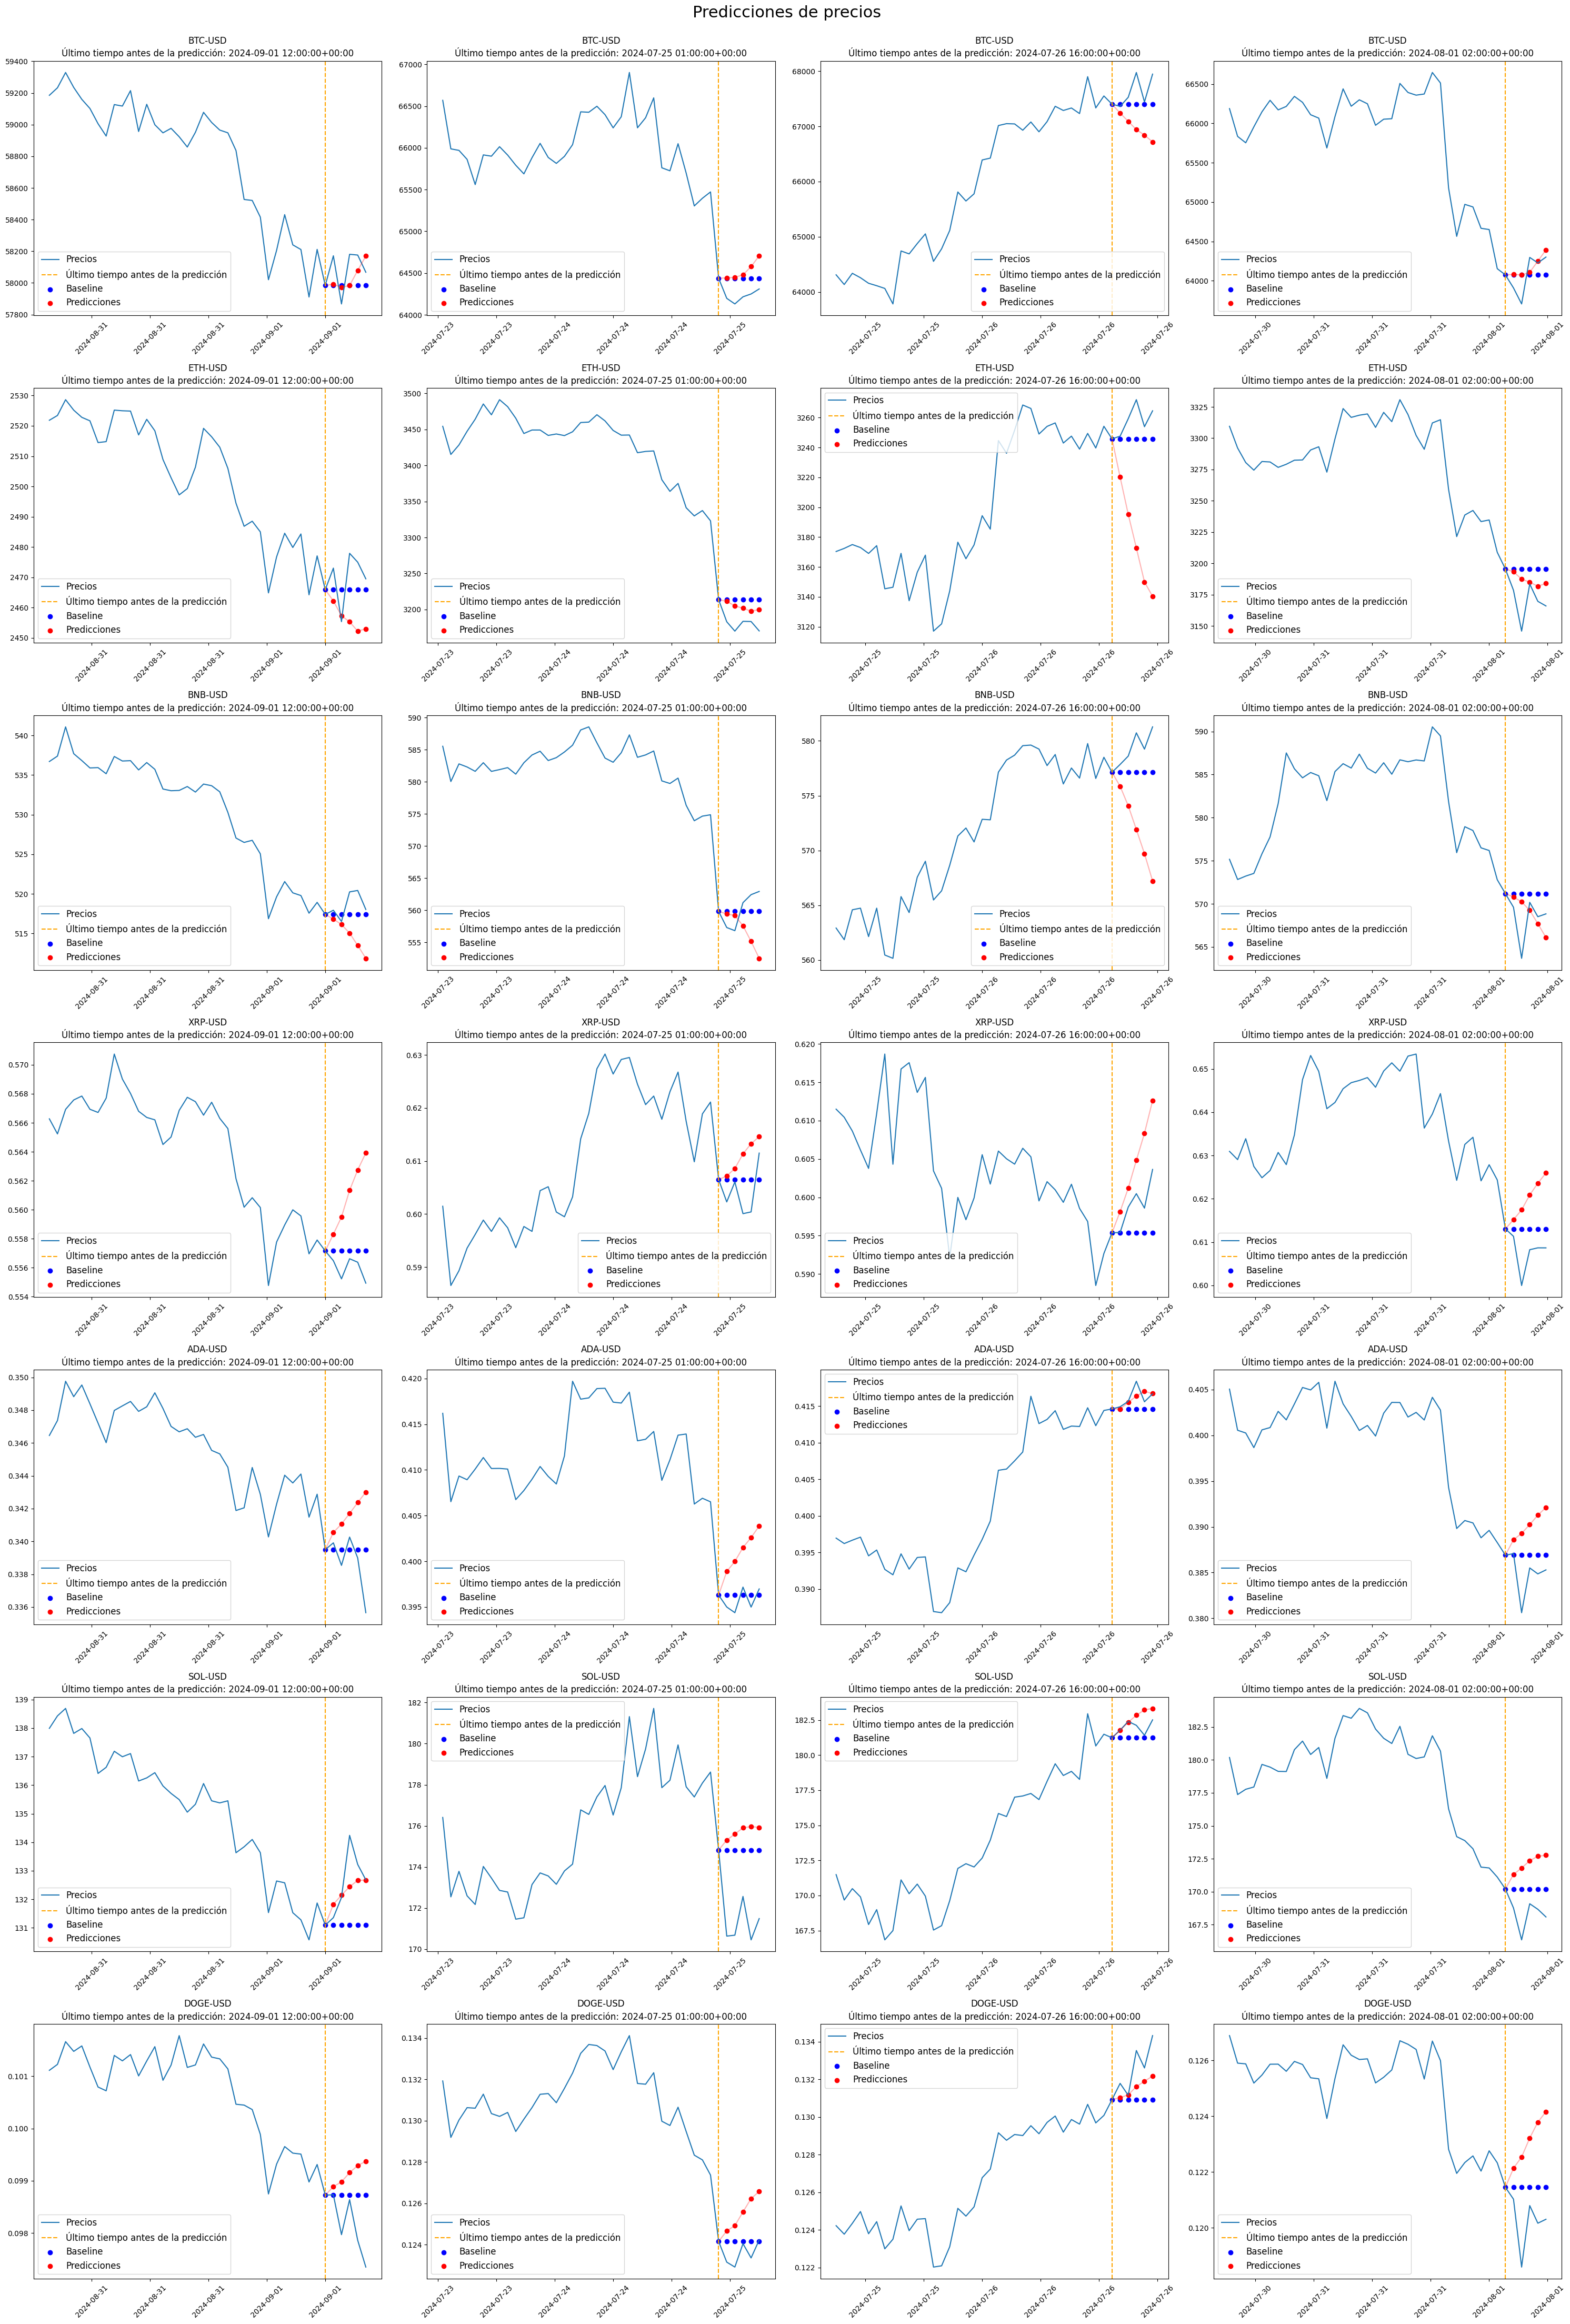

In [38]:
pred_minmax, pred_minmax_raw, mae_minmax, mae_minmax_raw = predictions_analysis(
    model=model_minmax,
    X_test=X_test_minmax,
    y_test=y_test_minmax,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: minmax_scaler_test.inverse_transform(data),
)

#### Predicción en escala logarítmica

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.18691642662029362
ETH-USD : 0.06981145174475231
BNB-USD : 0.32644743265849197
XRP-USD : 0.07347028742979851
ADA-USD : 0.33679355634103747
SOL-USD : 0.3000767557645356
DOGE-USD : 0.12400245487614198

Errores absolutos medios en la escala de los precios:
BTC-USD : 10104.604031579465
ETH-USD : 199.46190096544268
BNB-USD : 144.66303106279238
XRP-USD : 0.04079071446646108
ADA-USD : 0.14700374848634282
SOL-USD : 38.40870737002892
DOGE-USD : 0.012091605831671562


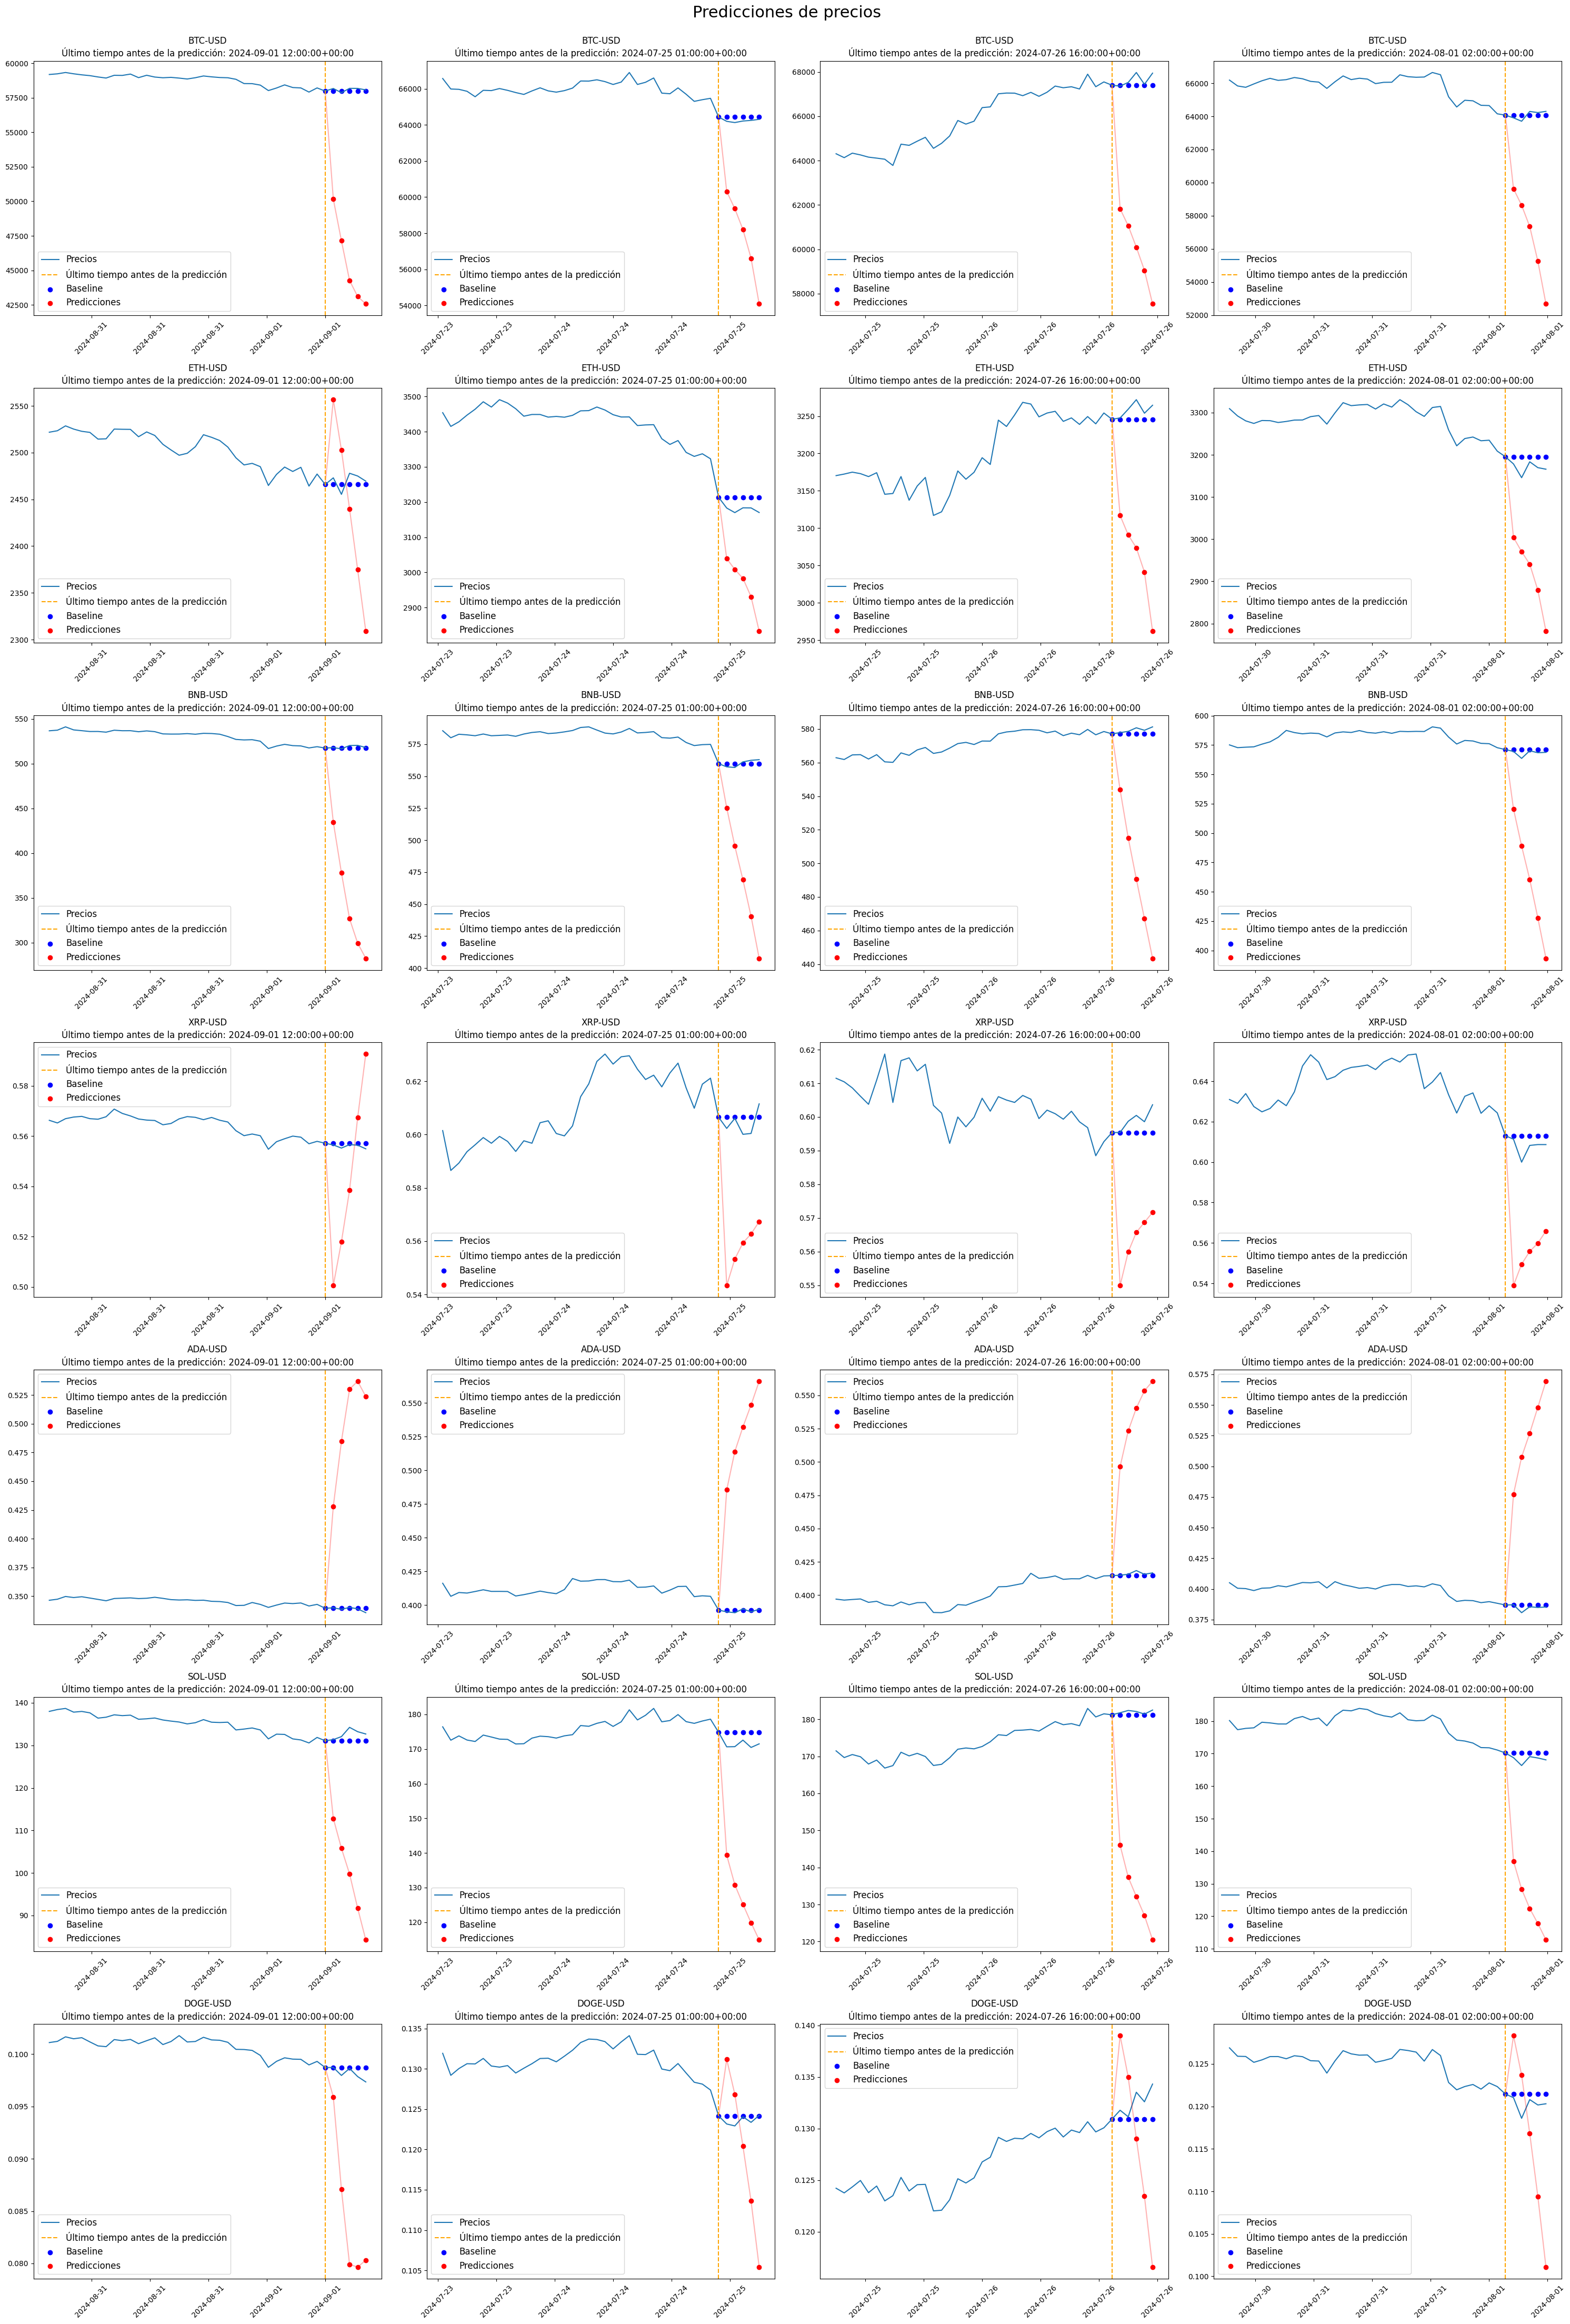

In [39]:
pred_log, pred_log_raw, mae_log, mae_log_raw = predictions_analysis(
    model=model_log,
    X_test=X_test_log,
    y_test=y_test_log,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: np.exp(data),
)

In [40]:
def plot_log_predictions(log_predictions: np.ndarray, random_seed: int = 0, window_size: int = 40):
    # function to plot log_predictions in four random times and for each crypto. 
    # columns in plot correspond to the selected times, and rows correspond to cryptos.
    
    np.random.seed(random_seed)
    rand_ind = np.random.choice(n_test-T, size=4, replace=False)
    
    n_rows, n_cols = 7, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

    fig.suptitle("Predicciones escala logarítmica", fontsize=22)

    # Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
    for j in range(n_cols):
        jth_time = index2timestamp(rand_ind[j], "test") # time t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1})
        jth_data = np.log(dataset_df.loc[
            jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
        ]) # from the window of size T starting at t, just consider the last window_size points
        
        pred_times = jth_data.index[-m:] # predicted times
        last_time = jth_data.index[-m-1] # last time t+\tau -1
        
        for i in range(n_rows):
            ith_crypto = cryptos[i]
            last_log_price = np.log(dataset_df.loc[last_time][ith_crypto])
            
            axes[i, j].plot(jth_data[ith_crypto], label="Log-Precios")
            axes[i, j].plot([last_time]+[t for t in pred_times], [last_log_price]+[pt for pt in log_predictions[rand_ind[j], :, i]], color="r", alpha=0.3)
            axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
            axes[i, j].scatter([last_time] + [t for t in pred_times], [last_log_price]*(m+1), color="b", label="Baseline")
            axes[i, j].scatter(pred_times, log_predictions[rand_ind[j], :, i], color="r", label="Predicciones")
            axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
            axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
            axes[i, j].tick_params(axis="x", labelrotation=45)
            axes[i,j ].legend(fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

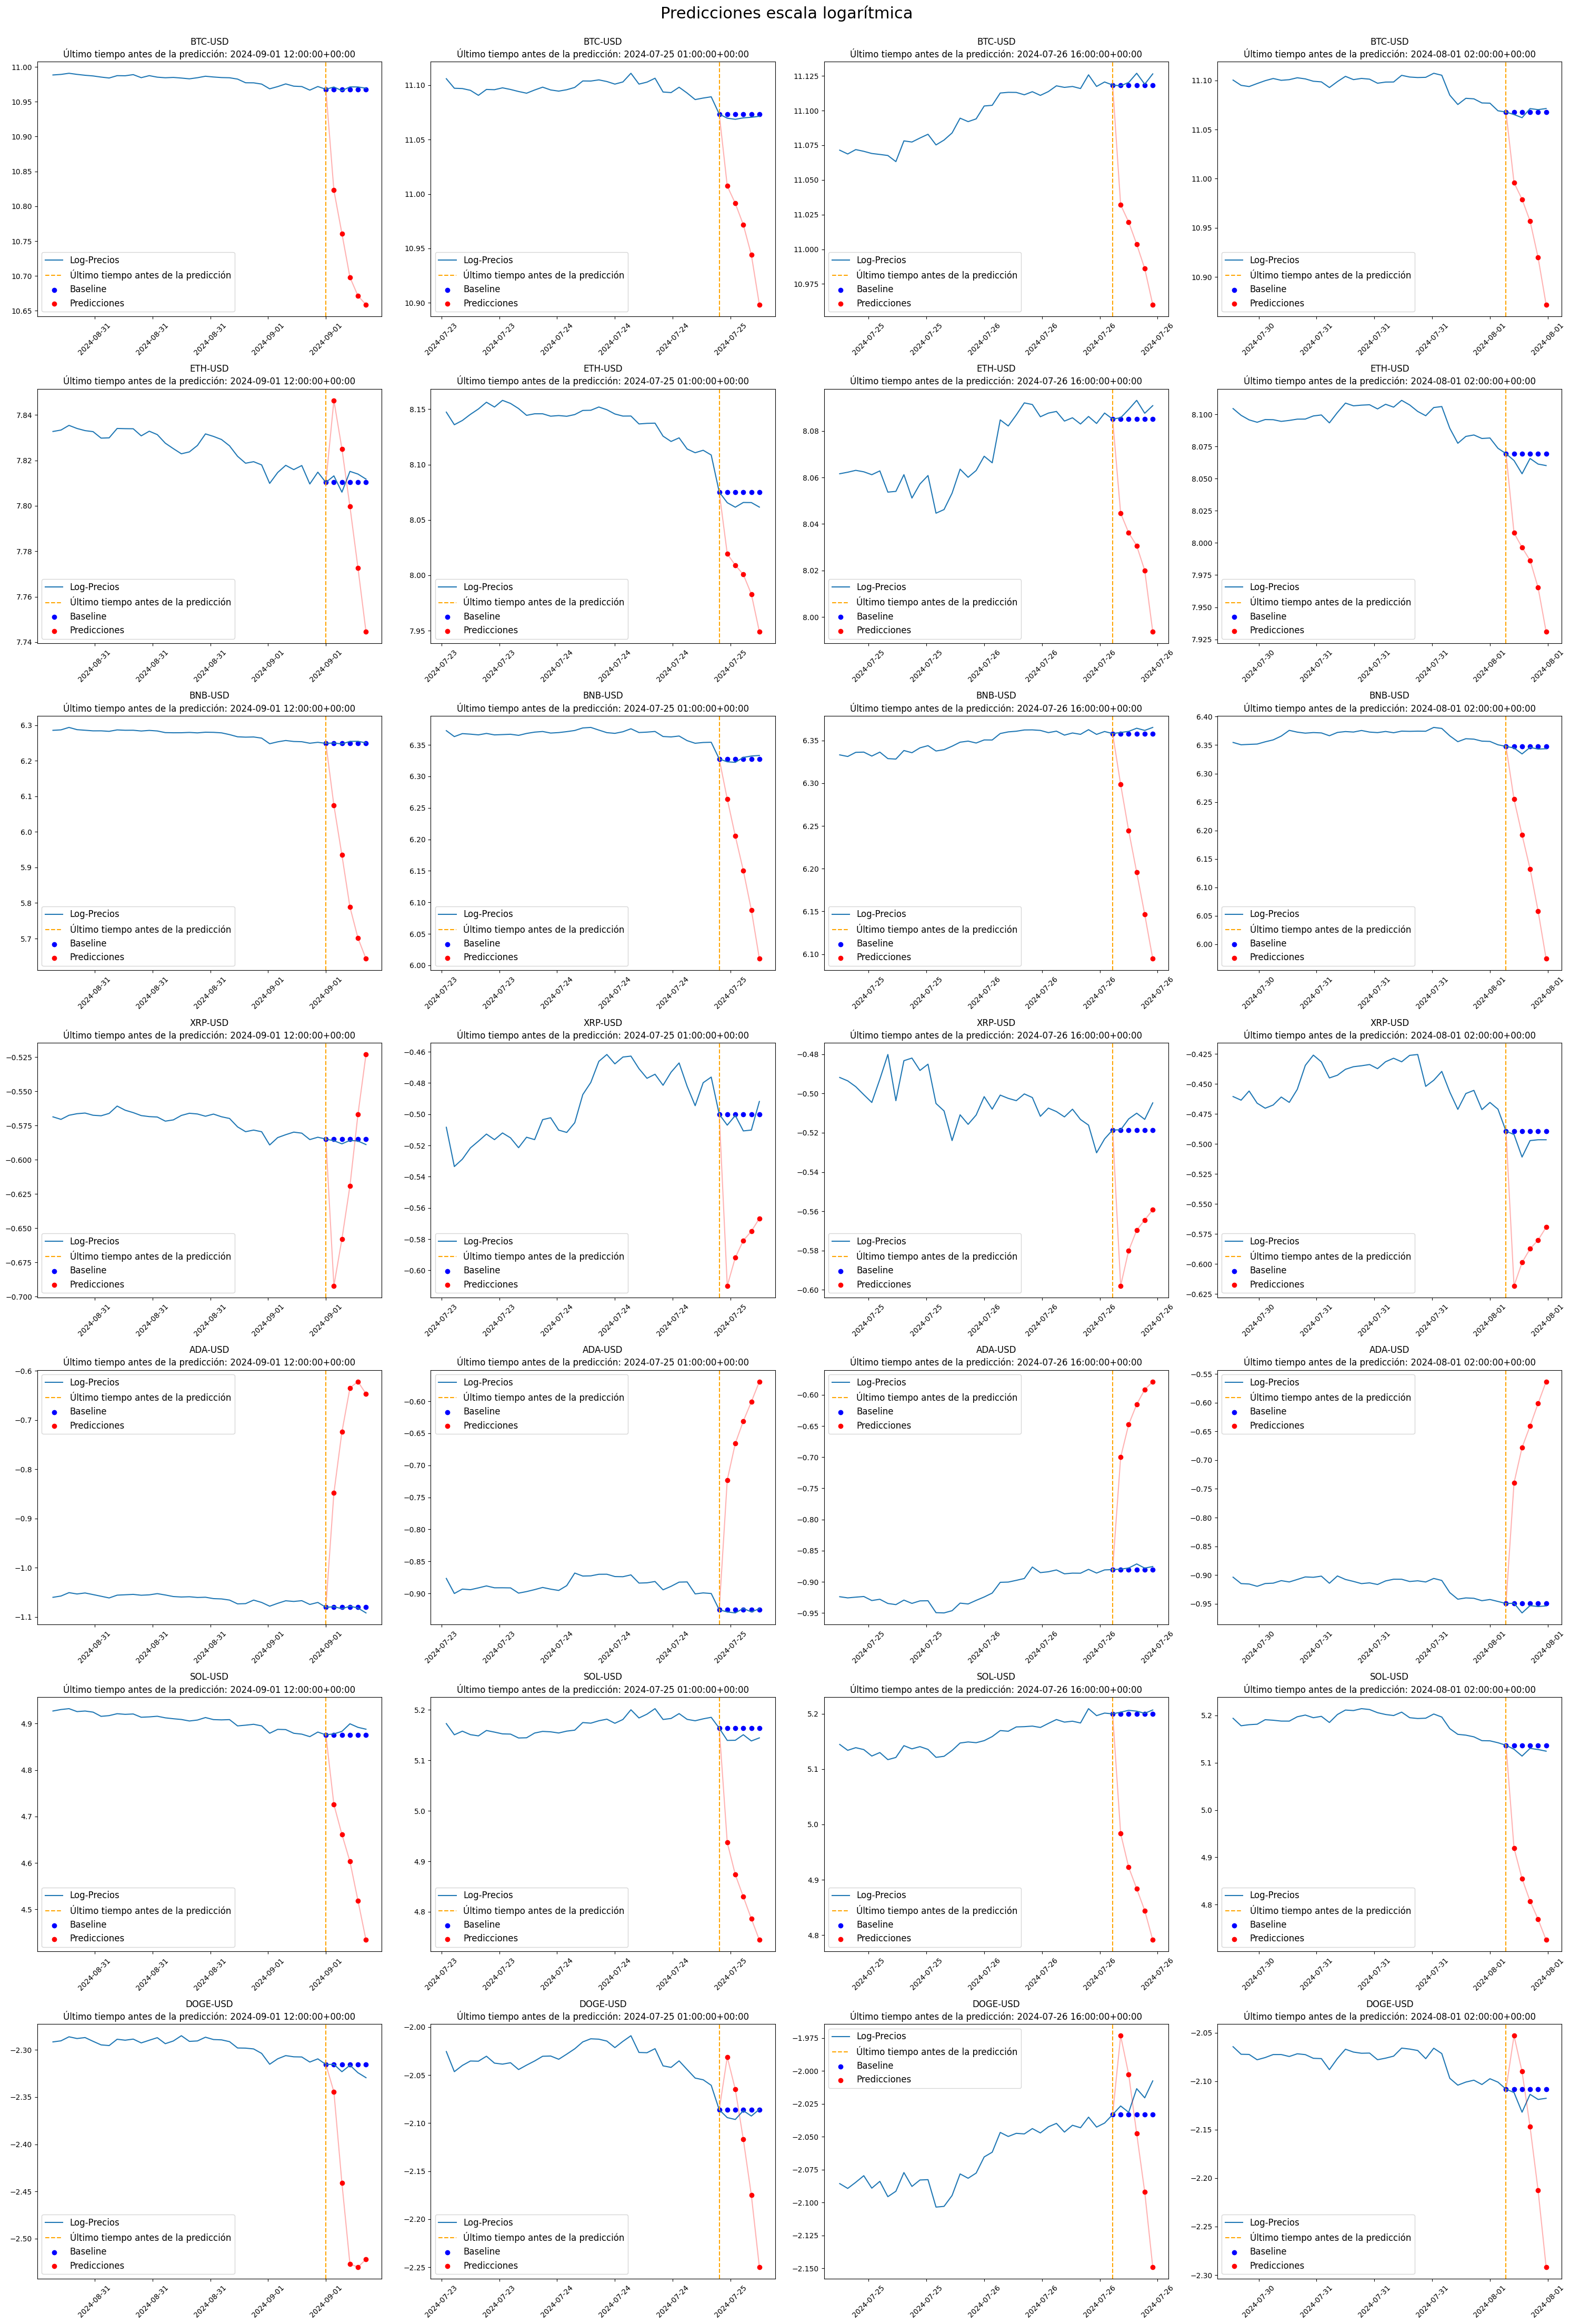

In [41]:
plot_log_predictions(pred_log)

## Resultados y conclusiones

El error absoluto medio cometido por el baseline en la escala de los precios se muestra a continuación.

In [43]:
baseline = np.zeros(shape=y_test_raw.shape)
for i in range(y_test_raw.shape[0]):
    baseline[i] = np.array([X_test_raw[i, -1, :] for _ in range(m)])
    
baseline_flat = baseline.reshape(-1, data_dim)
y_test_raw_flat = y_test_raw.reshape(-1, data_dim)

mae_baseline = mean_absolute_error(
    y_test_raw_flat, baseline_flat, multioutput="raw_values"
)

print("Errores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_baseline[i])

Errores absolutos medios en la escala de los precios:
BTC-USD : 408.4316001017792
ETH-USD : 21.930871508406213
BNB-USD : 3.790757282105228
XRP-USD : 0.005203885958048058
ADA-USD : 0.0033295072857807283
SOL-USD : 1.5674813890629713
DOGE-USD : 0.0010761421726537992


Para ver el performance de todos los modelos en conjunto, vamos a ver el histograma de errores absolutos medios (*MAE, Mean Absolute Error*) obtenidos en el conjunto de prueba por criptomoneda y por modelo.

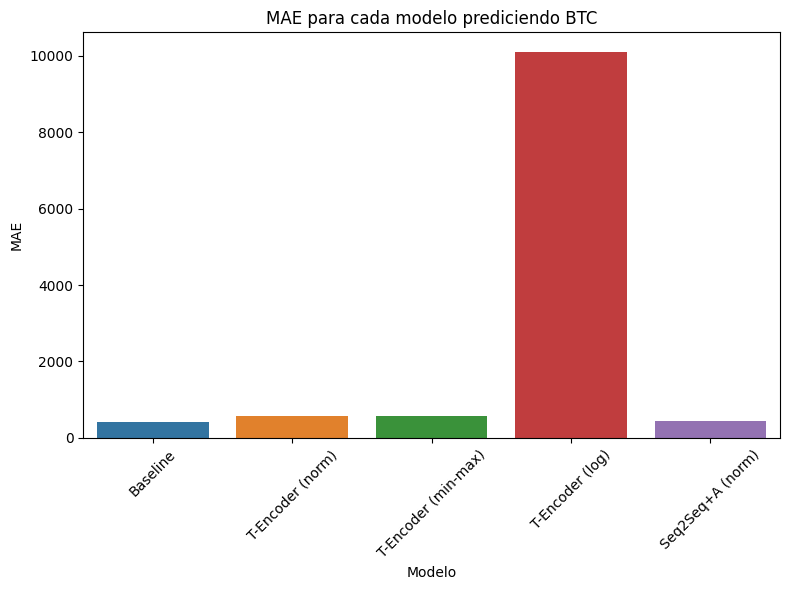

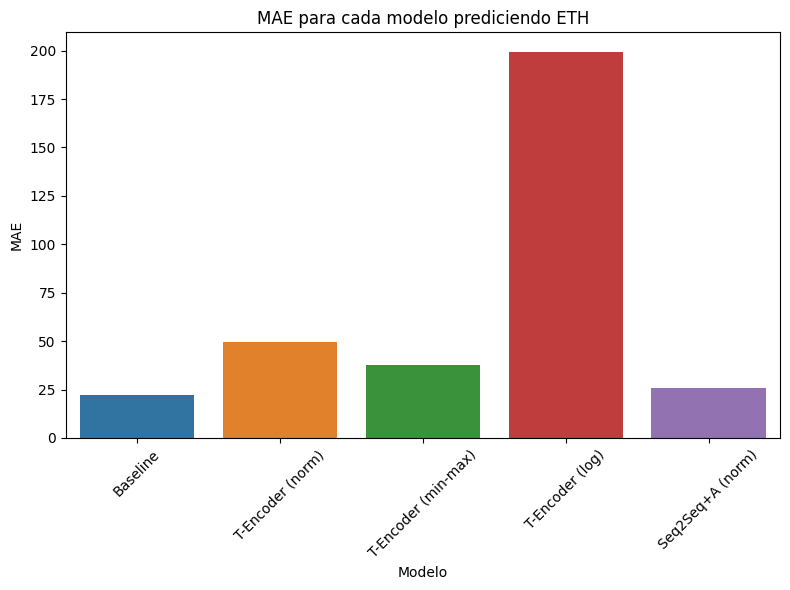

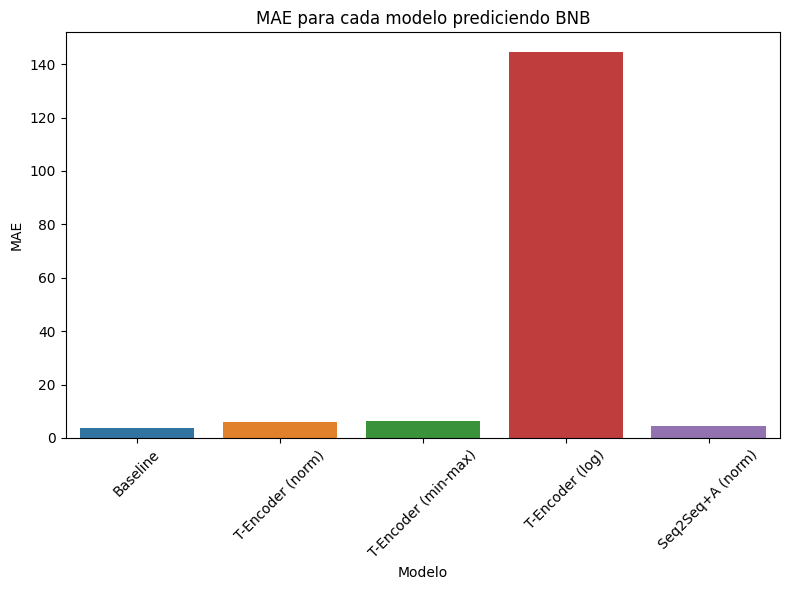

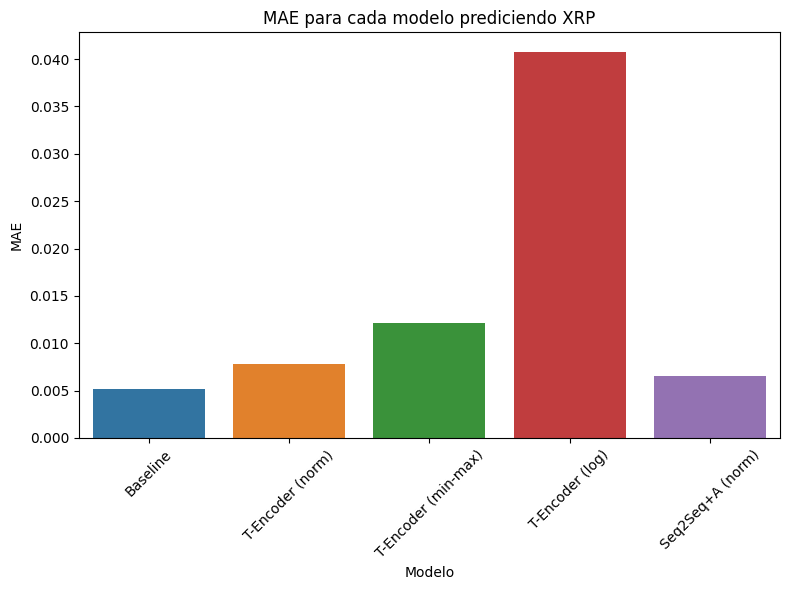

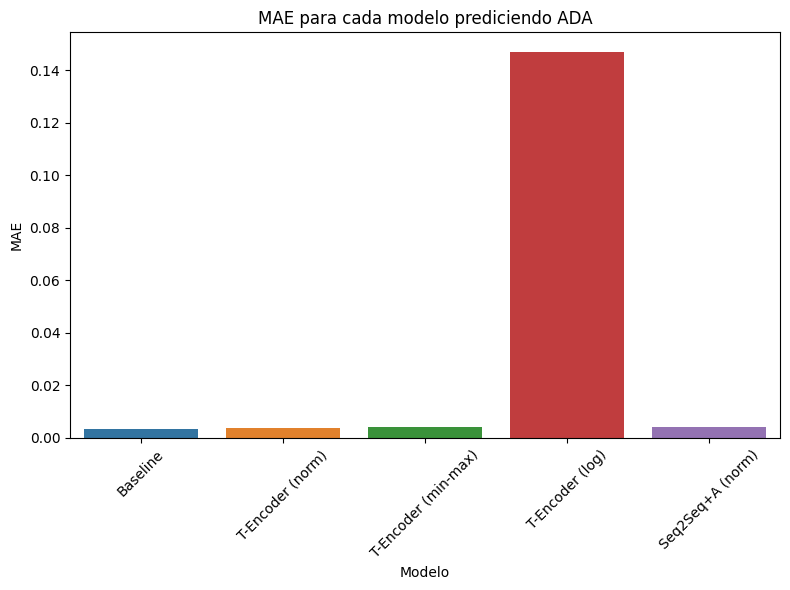

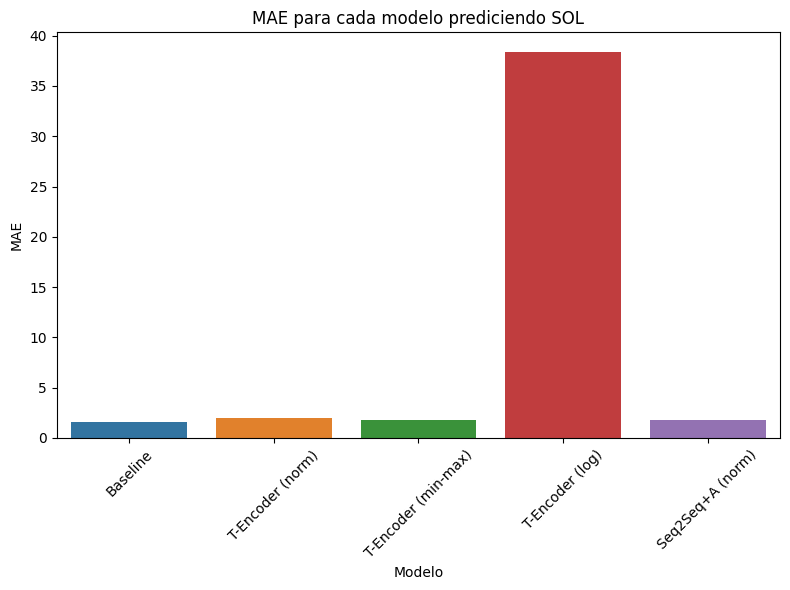

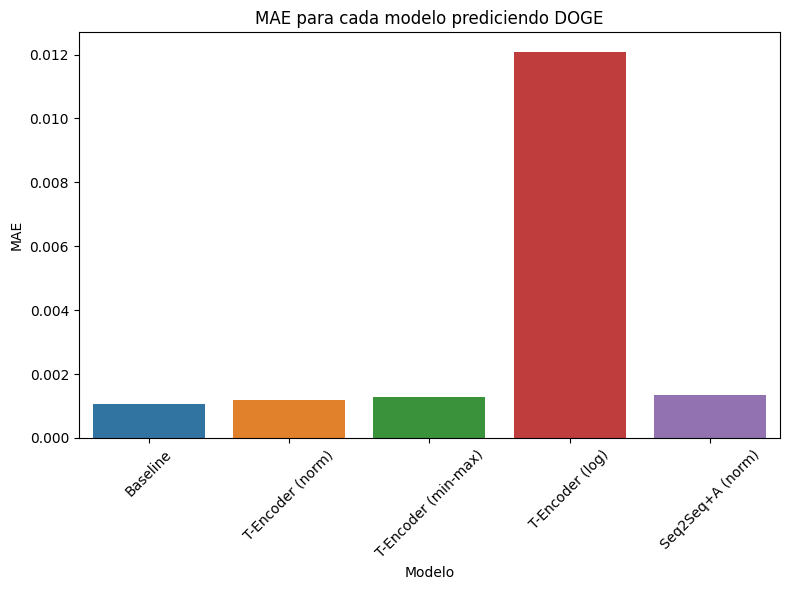

In [63]:
modelos = [
    "Baseline",
    "T-Encoder (norm)",
    "T-Encoder (min-max)",
    "T-Encoder (log)",
    "Seq2Seq+A (norm)",
]

errores = [mae_baseline, mae_norm_raw, mae_minmax_raw, mae_log_raw, mae_seq2seq_raw]
cripto_names = ["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"]

errors_dict = {"Modelo": [], "MAE": [], "Criptomoneda": []}

for i in range(len(modelos)):
    errors_dict["Modelo"] = errors_dict["Modelo"] + [modelos[i]] * 7
    errors_dict["MAE"] = errors_dict["MAE"] + errores[i].tolist()
    errors_dict["Criptomoneda"] = errors_dict["Criptomoneda"] + cripto_names

errors_df = pd.DataFrame(errors_dict)

for crypto in cripto_names:
    plt.figure(figsize=(8, 6))
    crypto_df = errors_df[errors_df["Criptomoneda"] == crypto]
    sns.barplot(data=crypto_df, x="Modelo", y="MAE", hue="Modelo", dodge=False)
    plt.title(f"MAE para cada modelo prediciendo {crypto}")
    plt.ylabel("MAE")
    plt.xlabel("Modelo")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Para que los errores estén en la misma escala y podamos comparar los errores de los modelos entre monedas, utilizaremos el *error absoluto medio normalizado* con respecto al baseline. Es decir, vamos a ver qué tan grandes son los errores de los modelos con respecto al error del baseline (i.e., ``MAE / MAE_BASELINE``). Dado que el modelo basado en el Transformer utilizando los datos en escala logarítmica tiene errores muy grandes, quitaremos el error relativo de este modelo.

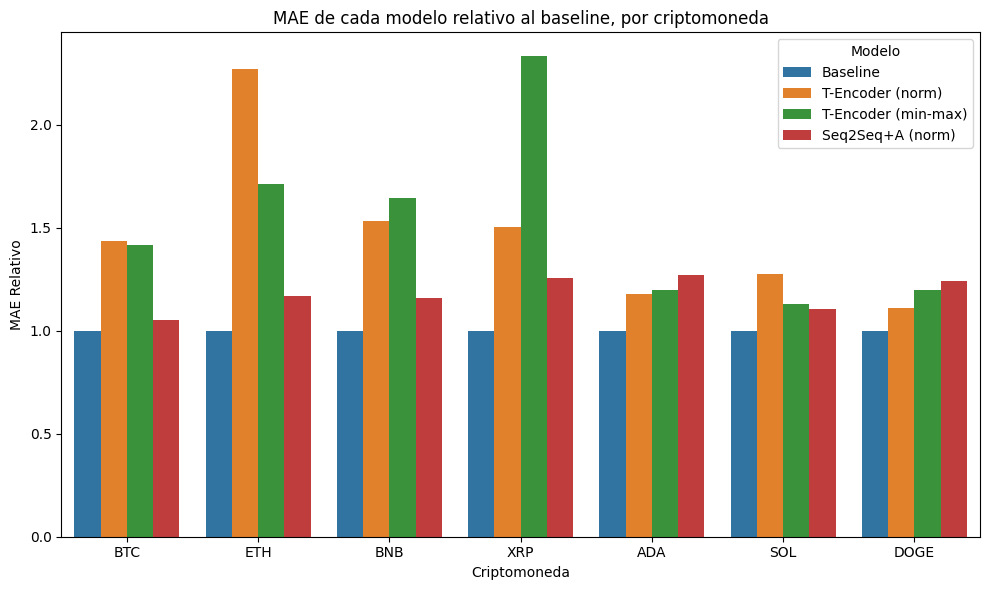

In [64]:
# compute relative MAE
normalized_errors = []
for i in range(len(modelos)):
    normalized_errors.append([mae / mae_baseline[j] for j, mae in enumerate(errores[i])])

errors_dict = {"Modelo": [], "MAE Relativo": [], "Criptomoneda": []}
for i in range(len(modelos)):
    errors_dict["Modelo"] = errors_dict["Modelo"] + [modelos[i]] * len(cripto_names)
    errors_dict["MAE Relativo"] = errors_dict["MAE Relativo"] + normalized_errors[i]
    errors_dict["Criptomoneda"] = errors_dict["Criptomoneda"] + cripto_names

errors_df = pd.DataFrame(errors_dict)
errors_df = errors_df[errors_df["Modelo"] != "T-Encoder (log)"]

plt.figure(figsize=(10, 6))
sns.barplot(data=errors_df, x="Criptomoneda", y="MAE Relativo", hue="Modelo")
plt.title("MAE de cada modelo relativo al baseline, por criptomoneda")
plt.ylabel("MAE Relativo")
plt.xlabel("Criptomoneda")
plt.tight_layout()
plt.show()

También mostramos una tabla con los errores MAE y en paréntesis el porcentaje relativo al MAE del baseline.

In [68]:
pd.DataFrame.from_dict(
    {
        "Baseline": [f"{mae:.2f} (100%)" for mae in mae_baseline],
        "Transformer Encoder (normalización)": [f"{mae:.2f} ({100*mae/mae_baseline[j]:.2f}%)" for j, mae in enumerate(mae_norm_raw)],
        "Transformer Encoder (banqueo)": [f"{mae:.2f} ({100*mae/mae_baseline[j]:.2f}%)" for j, mae in enumerate(mae_minmax_raw)],
        "Transformer Encoder (logaritmo)": [f"{mae:.2f} ({100*mae/mae_baseline[j]:.2f}%)" for j, mae in enumerate(mae_log_raw)],
        "Seq2Seq+Atención (normalización)": [f"{mae:.2f} ({100*mae/mae_baseline[j]:.2f}%)" for j, mae in enumerate(mae_seq2seq_raw)],
    },
    orient="index",
    columns=["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"],
)

BTC               ETH  \
Baseline                                   408.43 (100%)      21.93 (100%)   
Transformer Encoder (normalización)     586.55 (143.61%)   49.76 (226.91%)   
Transformer Encoder (banqueo)           579.31 (141.84%)   37.53 (171.12%)   
Transformer Encoder (logaritmo)      10104.60 (2474.00%)  199.46 (909.50%)   
Seq2Seq+Atención (normalización)        430.51 (105.41%)   25.65 (116.95%)   

                                                   BNB             XRP  \
Baseline                                   3.79 (100%)     0.01 (100%)   
Transformer Encoder (normalización)     5.81 (153.23%)  0.01 (150.59%)   
Transformer Encoder (banqueo)           6.23 (164.38%)  0.01 (233.22%)   
Transformer Encoder (logaritmo)      144.66 (3816.20%)  0.04 (783.85%)   
Seq2Seq+Atención (normalización)        4.40 (115.98%)  0.01 (125.66%)   

                                                 ADA               SOL  \
Baseline                                 0.00 (100%)       1.57 (100%)   
Transformer Encoder (normalización)   0.00 (118.07%)    2.00 (127.78%)   
Transformer Encoder (banqueo)         0.00 (119.92%)    1.77 (112.81%)   
Transformer Encoder (logaritmo)      0.15 (4415.18%)  38.41 (2450.35%)   
Seq2Seq+Atención (normalización)      0.00 (127.14%)    1.74 (110.70%)   

                                                DOGE  
Baseline                                 0.00 (100%)  
Transformer Encoder (normalización)   0.00 (110.96%)  
Transformer Encoder (banqueo)         0.00 (119.67%)  
Transformer Encoder (logaritmo)      0.01 (1123.61%)  
Seq2Seq+Atención (normalización)      0.00 (124.13%)

Podemos concluir que el preprocesamiento logarítmico no fue nada bueno, mientras que la normalización y banqueo local tienen comportamientos similares. Sin embargo, hay una moneda (ETH) en la que es mejor el preprocesamiento de normalización local comparado con el banqueo local, y también hay otra moneda donde es al revés (XRP). 

Con respecto a la comparación entre Seq2Seq con atención y el modelo basado en el transformer, Seq2Seq fue mejor en 5 monedas y hubo dos monedas (ADA y DODGE) en donde el modelo basado en el transformer era mejor (usando normalización local). Ningún modelo pudo ganarle al baseline.